## Liquid Specific Gravity Prediction of C7+ Fractions of Gas Samples From Molecular Weight (feat. PNA Composition)

<div class="highlights" id="key1">
    <div class="highlights-title">Summary To Save Your Time</div>
    <div class="highlights-content">Test</div>
</div>

## 1. Motivation

Characterizations of the C7+ fractions require three parameters: normal boiling point (T<sub>b</sub>), molecular weight (MW), and liquid specific gravity (SG<sub>liq</sub>). For crude oil sampe analysis, you will always have MW and SG<sub>liq</sub>, but realistically you never get T<sub>b</sub> of the plus fractions unless you specifically ask for distillation data (which you almost never do). Usually the T<sub>b</sub> values are estimated using T<sub>b</sub>-MW-SG<sub>liq</sub> correlation models. 

<strong><u>However, unlike crude oil analysis, gas sample analysis doesn't always come with liquid specific gravity,</u></strong> because it's a gas sample. It reports gas specific gravity instead, as in <a href="#fig-1" class="internal-link">Figure 1</a>. While some labs report provide calculated values for both SG<sub>liq</sub> and SG<sub>gas</sub>, many labs don't. Furthermore, for simple unextended gas analysis that reports only paraffinic compounds upto C6 or C7, the properties of the plus fractions assume some default ternary paraffinic mixture of n-hexane, n-heptane, and n-octane (usually 6:3:1 ratio), which results in underestimation of SG<sub>liq</sub> because it ignores the presence of naphthenic and aromatic fractions which have higher specific gravity than paraffins. This post provides backgrounds and guidance on how to estimate SG<sub>liq</sub> of plus fractions, such as C6+ or C7+, from molecular weight, using Paraffin-Naphthene-Aromatic (PNA) composition and Single-Carbon-Number (SCN) group correlations.

<div class="row full_screen_margin_40 mobile_responsive_plot_full_width" id="fig-1">
<div class="col"><img src="jupyter_images/liquid_sg_gas_analysis_1.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 1:</strong> Gas analysis sample taken from a separator operating @ 50 psig  &amp; 90F. The analysis is missing SG<sub>liq</sub>, which is required for characterization of the Heptanes Plus (C7+) fraction. While the analysis reports SG<sub>gas</sub> , this can't be directly used for process simulations. One can notice that the specific gravity reported in this analysis is relative to gas from <i>"(Air=1)"</i>. It this was SG<sub>liq</sub>, it would've been shown as <i>"(Water=1)"</i>.</p></div>

## 2. Impact of PNA composition on MW and SG<sub>liq</sub>

PNA composition indicates the ratio of each hydrocarbon group within the plus fractions. It's essentially a method to represent the plus fractions as a ternary mixture composed of paraffins, naphthenes, and aromatics. The reason that specifically these three are used are because first they are the primary hydrocarbon groups that make up most of unrefined crude oil and natural gas, and they show distinctively different characteristics from each other chemical formula and molecular structure. Skimming through <a href="#fig-2" class="internal-link">Figure 2</a>, <a href="#fig-3" class="internal-link">3</a>, <a href="#fig-4" class="internal-link">4</a>, and <a href="#fig-5" class="internal-link">5</a> may help you visually understand their distinctive properites. 

For the purposes of C6+ or C7+ characterizations, PNA composition matters because nathphenic and aromatic fractions have higher SG<sub>liq</sub> than paraffins at the same molecular weight (recall that process simulation for the plus fractions require both SG<sub>liq</sub> and MW), as can be seen in <a href="#fig-2" class="internal-link">Figure 2</a>. Developing a SG<sub>liq</sub> correlation from MW assuming pure paraffinic composition will result in underestimated values of SG<sub>liq</sub>.

<div class="row full_screen_margin_80 mobile_responsive_plot_full_width" id="fig-2">
<div class="col"><img src="jupyter_images/liquid_sg_MW_sg_liq.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 2:</strong> Scatter plot of known compounds upto n-hexadecane (C16H34) listed in the GPA 2145 table<sup><a class="internal-link" href="#id2" id="id21">[2]</a></sup>.</p></div>

<div class="solution_panel closed" style="margin-top: -10px">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (2)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from sklearn.linear_model import LinearRegression
from pint import UnitRegistry

# Initialize a unit registry
ureg = UnitRegistry()

df = pd.read_csv('GPA 2145-16 Compound Properties Table - English - Truncated and PNA Identified.csv')

x = df['Molar Mass [g/mol]']
y = df['Liq. Relative Density @60F:1atm']

# Labeling for displaying texts
labels = ['methane', 'propane', 'n-butane', 'n-heptane', 'n-octane', 'n-decane', 'cyclohexane', 'cyclopentane', 'ethane',
'n-dodecane','n-tetradecane','n-hexadecane', 'methanol', 'naphthalene', 'hydrogen', 'n-hexane', 'n-pentane', 'isopentane', 
 'sulfur dioxide', 'hydrogen sulfide', 'toluene', 'benzene', 'm-xylene', 'hexylbenzene', 
         'propylene', '1-butene', 'isobutane', 'cyclooctane',
         ]
df['Display Text'] = df['Compound'].isin(labels)

BTEX_idx = df[df['Is BTEX'] == True].index
aromatic_idx = df[df['Is Aromatic'] == True].index
non_HC_idx = df[df['Is Hydrocarbon'] == False].index
hydroxyl_idx = df[df['Is Hydroxyl'] == True].index
paraffinic_idx = df[df['Is Paraffinic'] == True].index
naphethenic_idx = df[df['Is Naphthenic'] == True].index
other_idx = df[df['Others'] == True].index
whole_idx = list(df.index)

fig, ax = plt.subplots(figsize=(8, 4.5))

alpha = 1
_1 = ax.scatter(x.loc[paraffinic_idx], y.loc[paraffinic_idx], s=50, edgecolor='k', alpha=alpha, label='Paraffinic')
_2 = ax.scatter(x.loc[naphethenic_idx], y.loc[naphethenic_idx], s=50, edgecolor='k', alpha=alpha, label='Naphthenic')
_3 = ax.scatter(x.loc[aromatic_idx], y.loc[aromatic_idx], s=50, edgecolor='k', alpha=alpha, label='Aromatic/BTEX')
_4 = ax.scatter(x.loc[hydroxyl_idx], y.loc[hydroxyl_idx], s=50, edgecolor='k', alpha=alpha, label='Hydroxylic')
_5 = ax.scatter(x.loc[non_HC_idx], y.loc[non_HC_idx], s=50, edgecolor='k', alpha=alpha, label='Non-HCs')
_6 = ax.scatter(x.loc[other_idx], y.loc[other_idx], s=50, edgecolor='k', alpha=alpha, label='Other-HCs')

c1 = _1.get_facecolor()[0]
c2 = _2.get_facecolor()[0]
c3 = _3.get_facecolor()[0]
c4 = _4.get_facecolor()[0]
c5 = _5.get_facecolor()[0]
c6 = _6.get_facecolor()[0]

ax.legend(fontsize=9, ncol=3, loc='lower right')

texts = df['Compound']
for i, txt in enumerate(texts):
    if df['Display Text'].loc[i]:
        c = c5
        ha ='left'
        va = 'top'
        icr_y = 0.01

        if ha == 'left':
            icr_x = 3
        else:
            icr_x = -3

        if df['Is Paraffinic'].loc[i]:
            c = c1
            ha ='left'
            va = 'top'
            icr_y = -0.01
            icr_x = 0

        if df['Is Naphthenic'].loc[i]:
            c = c2
            ha ='right'
            va = 'top'
            icr_y = -0.01
        if df['Is Aromatic'].loc[i]:
            c = c3
            va = 'bottom'
            ha = 'center'
        if df['Is Hydroxyl'].loc[i]:
            c = c4
            va = 'bottom'
            ha = 'center'
        if df['Others'].loc[i]:
            c = c6
            va = 'bottom'
            ha = 'center'
            icr_y = 0.01

        ax.annotate(txt, (x.loc[i] + icr_x, y.iloc[i] + icr_y), fontsize=10, c=c, ha=ha, va=va)

#ax.set_xlim(-65, None)
ax.set_ylim(0, 1.1)
ax.set_ylim(0.4, 0.95)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.minorticks_on()
ax.grid(axis='y', which='major', linestyle='--', color='grey', alpha=0.5)
ax.grid(axis='x', which='major', color='grey', linestyle='--', alpha=0.5)
ylim_top = ax.get_ylim()[1]
ax.axhline(ylim_top, color='white', linewidth=2)

ax.set_ylabel('Liquid Specific Gravity', fontsize=11)
ax.set_xlabel('Molecular Weight', fontsize=11)
ax.text(0.03, 0.08, 'aegis4048.github.io', fontsize=12, ha='left', va='center',
    transform=ax.transAxes, color='grey', alpha=0.5)

def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

bold_txt = setbold('MW vs. SG_{liq}')
plain_txt = ', for different compound groups'

"""
Run this code and re-import matplotlib in case Latex runtime error occurs:

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
"""

fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0.01, horizontalalignment='left', fontsize=12, y=0.96)
yloc = 0.875
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.01, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))
ax.annotate('Data source: GPA 2145-16', xy=(-0.11, -.12), xycoords='axes fraction', fontsize=9)

fig.tight_layout()

fig.savefig('liquid_sg_MW_sg_liq.png', dpi=300, bbox_inches='tight')
            </code>
        </pre>
    </div>
</div>

<div class="row full_screen_margin_80 mobile_responsive_plot_full_width" id="fig-3">
<div class="col"><img src="jupyter_images/liquid_sg_ghv_gas_vs_mw.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 3:</strong> Scatter plot of known compounds upto n-hexadecane (C16H34) listed in the GPA 2145 table<sup><a class="internal-link" href="#id2" id="id22">[2]</a></sup>.</p></div>

<div class="solution_panel closed" style="margin-top: -10px">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (3)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('GPA 2145-16 Compound Properties Table - English - Truncated and PNA Identified.csv')

# Labeling for displaying texts
labels = ['methane', 'propane', 'n-butane', 'n-heptane', 'n-octane', 'n-decane', 'cyclohexane', 'cyclopentane', 'ethane',
'n-dodecane','n-tetradecane','n-hexadecane', 'methanol', 'ethanol', 'naphthalene', 'isobutylcyclopentane', 'hydrogen',
 'sulfur dioxide', 'hydrogen sulfide', 'toluene', 'benzene', 'm-xylene', 'pentylbenzene', 'hexylbenzene',
         'propylene', '1-butene'
         ]
df['Display Text'] = df['Compound'].isin(labels)

BTEX_idx = df[df['Is BTEX'] == True].index
aromatic_idx = df[df['Is Aromatic'] == True].index
non_HC_idx = df[df['Is Hydrocarbon'] == False].index
hydroxyl_idx = df[df['Is Hydroxyl'] == True].index
paraffinic_idx = df[df['Is Paraffinic'] == True].index
naphethenic_idx = df[df['Is Naphthenic'] == True].index
other_idx = df[df['Others'] == True].index
whole_idx = list(df.index)

x = df['Molar Mass [g/mol]']
y = df['Gross Heating Value Ideal Gas [Btu/ft^3]']

##################################### Plotting #######################################

fig, ax = plt.subplots(figsize=(8, 4.5))

alpha = 1
_1 = ax.scatter(x.loc[paraffinic_idx], y.loc[paraffinic_idx], s=50, edgecolor='k', alpha=alpha, label='Paraffinic')
_2 = ax.scatter(x.loc[naphethenic_idx], y.loc[naphethenic_idx], s=50, edgecolor='k', alpha=alpha, label='Naphthenic')
_3 = ax.scatter(x.loc[aromatic_idx], y.loc[aromatic_idx], s=50, edgecolor='k', alpha=alpha, label='Aromatic/BTEX')
_4 = ax.scatter(x.loc[hydroxyl_idx], y.loc[hydroxyl_idx], s=50, edgecolor='k', alpha=alpha, label='Hydroxylic')
_5 = ax.scatter(x.loc[non_HC_idx], y.loc[non_HC_idx], s=50, edgecolor='k', alpha=alpha, label='Non-HCs')
_6 = ax.scatter(x.loc[other_idx], y.loc[other_idx], s=50, edgecolor='k', alpha=alpha, label='Other-HCs')

c1 = _1.get_facecolor()[0]
c2 = _2.get_facecolor()[0]
c3 = _3.get_facecolor()[0]
c4 = _4.get_facecolor()[0]
c5 = _5.get_facecolor()[0]
c6 = _6.get_facecolor()[0]

ax.legend(fontsize=9, ncol=3)

texts = df['Compound']
for i, txt in enumerate(texts):
    if df['Display Text'].loc[i]:
        c = c5
        ha ='left'
        va = 'top'
        
        if df['Is Paraffinic'].loc[i]: 
            c = c1
            ha ='right'
            va = 'bottom'
        if df['Is Naphthenic'].loc[i]:
            c = c2
            ha ='right'
            va = 'bottom'
        if df['Is Aromatic'].loc[i]:
            c = c3
            va = 'top'
            ha = 'left'
        if df['Is Hydroxyl'].loc[i]:
            c = c4
            va = 'bottom'
            ha = 'left'
        if df['Others'].loc[i]:
            c = c6
            va = 'top'
            ha = 'left'
        
        if ha == 'left':
            icr = 3
        else:
            icr= -3
        
        ax.annotate(txt, (x.loc[i] + icr, y.iloc[i]), fontsize=10, c=c, ha=ha, va=va)

ax.minorticks_on()
ax.grid(axis='y', which='major', linestyle='--', color='grey', alpha=0.5)
#ax.grid(axis='y', which='minor', linestyle='--', color='grey', alpha=0.2)
#ax.grid(axis='x', which='minor', color='grey', linestyle='--', alpha=0.2)
ax.grid(axis='x', which='major', color='grey', linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Molecular Weight', fontsize=11)
ax.set_ylabel('Gross Heating Value [Btu/scf]', fontsize=11)
ax.text(0.99, 0.1, 'aegis4048.github.io', fontsize=12, ha='right', va='center',
    transform=ax.transAxes, color='grey', alpha=0.5)

#ax.set_xlim(0, 1)
#ax.set_ylim(10000, 30000)

def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

bold_txt = setbold('GHV_{gas} vs. MW')
plain_txt = ', for different compound groups'

fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=12, y=0.96)
yloc = 0.88
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

ax.annotate('Data source: GPA 2145-16', xy=(-0.11, -.12), xycoords='axes fraction', fontsize=9)

fig.tight_layout()

fig.savefig('liquid_sg_ghv_gas_vs_mw.png', dpi=300, bbox_inches='tight')
            </code>
        </pre>
    </div>
</div>

<div class="row full_screen_margin_80 mobile_responsive_plot_full_width" id="fig-4">
<div class="col"><img src="jupyter_images/liquid_sg_Tb_sg_liq.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 4:</strong> Scatter plot of known compounds upto n-hexadecane (C16H34) listed in the GPA 2145 table<sup><a class="internal-link" href="#id2" id="id23">[2]</a></sup>.</p></div>

<div class="solution_panel closed" style="margin-top: -10px">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (4)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from sklearn.linear_model import LinearRegression
from pint import UnitRegistry

# Initialize a unit registry
ureg = UnitRegistry()

df = pd.read_csv('GPA 2145-16 Compound Properties Table - English - Truncated and PNA Identified.csv')

x = df['Boiling T. [F]']
y = df['Liq. Relative Density @60F:1atm']

BTEX_idx = df[df['Is BTEX'] == True].index
aromatic_idx = df[df['Is Aromatic'] == True].index
non_HC_idx = df[df['Is Hydrocarbon'] == False].index
hydroxyl_idx = df[df['Is Hydroxyl'] == True].index
paraffinic_idx = df[df['Is Paraffinic'] == True].index
naphethenic_idx = df[df['Is Naphthenic'] == True].index
other_idx = df[df['Others'] == True].index
whole_idx = list(df.index)

fig, ax = plt.subplots(figsize=(8, 4.5))

alpha = 1
_1 = ax.scatter(x.loc[paraffinic_idx], y.loc[paraffinic_idx], s=50, edgecolor='k', alpha=alpha, label='Paraffinic')
_2 = ax.scatter(x.loc[naphethenic_idx], y.loc[naphethenic_idx], s=50, edgecolor='k', alpha=alpha, label='Naphthenic')
_3 = ax.scatter(x.loc[aromatic_idx], y.loc[aromatic_idx], s=50, edgecolor='k', alpha=alpha, label='Aromatic/BTEX')
_4 = ax.scatter(x.loc[hydroxyl_idx], y.loc[hydroxyl_idx], s=50, edgecolor='k', alpha=alpha, label='Hydroxylic')
_5 = ax.scatter(x.loc[non_HC_idx], y.loc[non_HC_idx], s=50, edgecolor='k', alpha=alpha, label='Non-HCs')
_6 = ax.scatter(x.loc[other_idx], y.loc[other_idx], s=50, edgecolor='k', alpha=alpha, label='Other-HCs')

c1 = _1.get_facecolor()[0]
c2 = _2.get_facecolor()[0]
c3 = _3.get_facecolor()[0]
c4 = _4.get_facecolor()[0]
c5 = _5.get_facecolor()[0]
c6 = _6.get_facecolor()[0]

ax.legend(fontsize=9, ncol=3, loc='lower right')

labels = ['methane', 'propane', 'n-butane', 'n-heptane', 'n-octane', 'n-decane', 'cyclohexane', 'cyclopentane', 'ethane',
'n-dodecane','n-tetradecane','n-hexadecane', 'methanol', 'ethanol', 'naphthalene', 'hydrogen', 'cyclooctane',
 'sulfur dioxide', 'hydrogen sulfide', 'toluene', 'benzene', 'm-xylene', 'hexylbenzene',
         '1-butene', 'isobutane', 'n-pentane', 'isopentane', '2,2-dimethylpropane', 'n-hexane', 'n-nonane'
         ]
df['Display Text'] = df['Compound'].isin(labels)

texts = df['Compound']
for i, txt in enumerate(texts):
    if df['Display Text'].loc[i]:
        c = c5
        ha ='left'
        va = 'top'
        icr_y = 0.01

        if ha == 'left':
            icr_x = 3
        else:
            icr_x = -3

        if df['Is Paraffinic'].loc[i]:
            c = c1
            ha ='left'
            va = 'top'
            icr_y = -0.01
            icr_x = 0

        if df['Is Naphthenic'].loc[i]:
            c = c2
            ha ='right'
            va = 'top'
            icr_y = -0.01
        if df['Is Aromatic'].loc[i]:
            c = c3
            va = 'bottom'
            ha = 'center'
        if df['Is Hydroxyl'].loc[i]:
            c = c4
            va = 'bottom'
            ha = 'center'
        if df['Others'].loc[i]:
            c = c6
            va = 'top'
            ha = 'right'

        ax.annotate(txt, (x.loc[i] + icr_x, y.iloc[i] + icr_y), fontsize=10, c=c, ha=ha, va=va)

ax.set_xlim(-65, None)
ax.set_ylim(0.4, 0.95)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.minorticks_on()
ax.grid(axis='y', which='major', linestyle='--', color='grey', alpha=0.5)
ax.grid(axis='x', which='major', color='grey', linestyle='--', alpha=0.5)
ylim_top = ax.get_ylim()[1]
ax.axhline(ylim_top, color='white', linewidth=2)

ax.set_ylabel('Liquid Specific Gravity', fontsize=11)
ax.set_xlabel('Normal Boiling Temperature [F]', fontsize=11)
ax.text(0.03, 0.08, 'aegis4048.github.io', fontsize=12, ha='left', va='center',
    transform=ax.transAxes, color='grey', alpha=0.5)

def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

bold_txt = setbold('T_{b} vs. SG_{liq}')
plain_txt = ', for different compound groups'

"""
Run this code and re-import matplotlib in case Latex runtime error occurs:

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
"""

fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0.01, horizontalalignment='left', fontsize=12, y=0.96)
yloc = 0.875
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.01, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))
ax.annotate('Data source: GPA 2145-16', xy=(-0.11, -.12), xycoords='axes fraction', fontsize=9)

fig.tight_layout()
fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

<div class="row full_screen_margin_80 mobile_responsive_plot_full_width" id="fig-5">
<div class="col"><img src="jupyter_images/liquid_sg_ghv_liq_vs_sg_liq.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 5:</strong> Scatter plot of known compounds upto n-hexadecane (C16H34) listed in the GPA 2145 table<sup><a class="internal-link" href="#id2" id="id24">[2]</a></sup>.</p></div>

<div class="solution_panel closed" style="margin-top: -10px">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (5)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('GPA 2145-16 Compound Properties Table - English - Truncated and PNA Identified.csv')

x = df['Gross Heating Value Ideal Gas [Btu/lbm]']
y = df['Liq. Relative Density @60F:1atm']

BTEX_idx = df[df['Is BTEX'] == True].index
aromatic_idx = df[df['Is Aromatic'] == True].index
non_HC_idx = df[df['Is Hydrocarbon'] == False].index
hydroxyl_idx = df[df['Is Hydroxyl'] == True].index
paraffinic_idx = df[df['Is Paraffinic'] == True].index
naphethenic_idx = df[df['Is Naphthenic'] == True].index
other_idx = df[df['Others'] == True].index
whole_idx = list(df.index)

fig, ax = plt.subplots(figsize=(8, 4.5))

alpha = 1
_1 = ax.scatter(x.loc[paraffinic_idx], y.loc[paraffinic_idx], s=50, edgecolor='k', alpha=alpha, label='Paraffinic')
_2 = ax.scatter(x.loc[naphethenic_idx], y.loc[naphethenic_idx], s=50, edgecolor='k', alpha=alpha, label='Naphthenic')
_3 = ax.scatter(x.loc[aromatic_idx], y.loc[aromatic_idx], s=50, edgecolor='k', alpha=alpha, label='Aromatic/BTEX')
_4 = ax.scatter(x.loc[hydroxyl_idx], y.loc[hydroxyl_idx], s=50, edgecolor='k', alpha=alpha, label='Hydroxylic')
_5 = ax.scatter(x.loc[non_HC_idx], y.loc[non_HC_idx], s=50, edgecolor='k', alpha=alpha, label='Non-HCs')
_6 = ax.scatter(x.loc[other_idx], y.loc[other_idx], s=50, edgecolor='k', alpha=alpha, label='Other-HCs')

c1 = _1.get_facecolor()[0]
c2 = _2.get_facecolor()[0]
c3 = _3.get_facecolor()[0]
c4 = _4.get_facecolor()[0]
c5 = _5.get_facecolor()[0]
c6 = _6.get_facecolor()[0]

ax.legend(fontsize=9, ncol=3, loc='upper right')

labels = ['methane', 'propane', 'n-butane', 'n-heptane', 'n-octane', 'n-decane', 'cyclohexane', 'cyclopentane', 'ethane',
'n-pentadecane', 'naphthalene', 'hydrogen', 'n-hexane', 'n-pentane',
 'sulfur dioxide', 'hydrogen sulfide', 'toluene', 'benzene', 'm-xylene','hexylbenzene', 'styrene',
         'propylene', '1-butene',
         ]
df['Display Text'] = df['Compound'].isin(labels)

texts = df['Compound']
for i, txt in enumerate(texts):
    if df['Display Text'].loc[i]:
        c = c5
        ha ='left'
        va = 'top'

        y_icr = 0
        if df['Is Paraffinic'].loc[i]:
            c = c1
            ha ='left'
            va = 'bottom'
        if df['Is Naphthenic'].loc[i]:
            c = c2
            ha ='right'
            va = 'top'
        if df['Is Aromatic'].loc[i]:
            c = c3
            va = 'bottom'
            ha = 'left'
        if df['Is Hydroxyl'].loc[i]:
            c = c4
            va = 'bottom'
            ha = 'left'
        if df['Others'].loc[i]:
            c = c6
            va = 'top'
            ha = 'right'

        if txt in ['benzene', 'styrene',]:
            ha = 'right'
        if txt in ['styrene']:
            va = 'bottom'
        if txt in ['toluene']:
            ha = 'center'
            va = 'top'
            y_icr = -0.01
        if txt in ['m-xylene']:
            ha = 'left'
            va = 'bottom'
            y_icr = 0.05

        if ha == 'left':
            icr = 100
        else:
            icr= -50

        ax.annotate(txt, (x.loc[i] + icr, y.iloc[i] + y_icr), fontsize=10, c=c, ha=ha, va=va)

ax.set_xlim(17000, 25000)
ax.set_ylim(0.2, 1.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.minorticks_on()
ax.grid(axis='y', which='major', linestyle='--', color='grey', alpha=0.5)
ax.grid(axis='x', which='major', color='grey', linestyle='--', alpha=0.5)
ylim_top = ax.get_ylim()[1]
ax.axhline(ylim_top, color='white', linewidth=2)

ax.set_xlabel('Liquid Gross Heating Value [Btu/lbm]', fontsize=11)
ax.set_ylabel('Liquid Specific Gravity', fontsize=11)
ax.text(0.03, 0.08, 'aegis4048.github.io', fontsize=12, ha='left', va='center',
    transform=ax.transAxes, color='grey', alpha=0.5)

def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

bold_txt = setbold('GHV_{liq} vs. SG_{liq}')
plain_txt = ', for different compound groups'

"""
Run this code and re-import matplotlib in case Latex runtime error occurs:

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
"""

fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0.01, horizontalalignment='left', fontsize=12, y=0.96)
yloc = 0.875
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.01, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))
ax.annotate('Data source: GPA 2145-16', xy=(-0.11, -.12), xycoords='axes fraction', fontsize=9)

fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

<div class="alert alert-info" id="what_is_PNA">
    <h4>Notes: What are paraffins, naphthenes, and aromatics?</h4>
    <p>Paraffins, naphtehens, and aromatics are the primary hydrocarbon groups 
        that make up compositions of the naturally occuring crude oil and gas. The below is a brief on each of them: </p>    
    <p><strong>Paraffins:</strong> Known as alkanes, paraffins follow the general formula $C_nH_{2n+2}$. This group is characterized by its high hydrogen to carbon ratio, contributing to their higher energy density per mass compared to other hydrocarbon types. Examples include Methane (CH₄), Ethane (C₂H₆), Propane (C₃H₈), Butane (C₄H₁₀), Pentane (C₅H₁₂), Hexane (C₆H₁₄), Heptane (C₇H₁₆), Octane (C₈H₁₈), Nonane (C₉H₂₀), and Decane (C₁₀H₂₂).</p>
    <p><strong>Naphthenes:</strong> Also known as cycloalkanes, naphthenes are very similar to paraffins and follow the general chemical formula $C_nH_{2n}$. Compounds typically containing "cyclo" in their names are considered naphthenic. Examples are Cyclopropane (C₃H₆), Cyclobutane (C₄H₈), Cyclopentane (C₅H₁₀), Cyclohexane (C₆H₁₂), Cycloheptane (C₇H₁₄), Cyclooctane (C₈H₁₆), Cyclononane (C₉H₁₈), Cyclodecane (C₁₀H₂₀), Methylcyclopentane (C₆H₁₂), and Ethylcyclohexane (C₈H₁₆).</p>
    <p><strong>Aromatics:</strong> This class of hydrocarbons is characterized by one or more benzene rings in their molecular structure. The simplest aromatic compound, benzene, has the chemical formula $C_6H_6$. Aromatic compounds generally follow the formula $C_nH_n$ for monocyclic aromatics, but the presence of multiple rings and substituents can alter this formula. The carbon to hydrogen ratio for aromatics is generally 1:1, less than half of paraffins, explaining aromatics' lower energy density per mass. BTEX compounds fall within this class. Examples include Benzene (C₆H₆), Toluene (C₇H₈), Ethylbenzene (C₈H₁₀), o-Xylene (C₈H₁₀), m-Xylene (C₈H₁₀), p-Xylene (C₈H₁₀), Styrene (C₈H₈), Naphthalene (C₁₀H₈), Phenol (C₆H₅OH), and Aniline (C₆H₅NH₂).</p>
</div>

## 3. Problems with plus fractions in un-extended gas analysis

<div class="highlights" id="key1">
<div class="highlights-title">Summary</div>
<div class="highlights-content">C6+ fractions in simple un-extended gas analysis assume a fixed pure paraffinic pseudo-compound of 60% hexane, 30% heptane, and 10% octane. Because the fraction is assumed to be purely paraffinic (no naphthenics and aromatics), such ternary mixture underestimates SG<sub>liq</sub> while overestimating MW for C6+.</div>
</div>

For simple un-extended gas analysis, it is a common practice to assume a ternary composition of hexane, heptane, and octane to replace the plus fractions, because natural gas samples have negligible volumes of <i>"heavy-ends"</i> starting from n-nonane. Traditionally for C6+ fractions, the ratio is fixed at 60% n-hexane, 30% n-heptane, and 10% n-octane. Note that this ratio is arbitrary; the GPA 2286 standard<sup><a class="internal-link" href="#id3" id="id31">[3]</a></sup> states that <i>"Constant values for hexanes plus (C6+) or heptanes plus (C7+) if not actually determined by extended analysis should be
mutually agreed upon by all concerned parties."</i> Some reports explicitly show the assumed ratio, as shown in <a href="#fig-6" class="internal-link">Figure 6</a>. The calculated properites of the report is further validated through a process simulation software, as shown in <a href="#fig-7" class="internal-link">Figure 7</a>.

<div class="row full_screen_margin_100 mobile_responsive_plot_full_width" id="fig-6">
<div class="col"><img src="jupyter_images/liquid_sg_c6_assumed_ratio.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 6:</strong> Gas analysis of a sample taken at an atmospheric tank. It explicitly shows the assumed ternary mixture ratio of 6:3:1 for the Hexanes Plus (C6+) fraction.</p></div>

<div class="row full_screen_margin_80 mobile_responsive_plot_full_width" id="fig-7">
<div class="col"><img src="jupyter_images/liquid_sg_C6_assumed_ratio_promax.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 7:</strong> BRE Promax screenshot, which replicates the above gas sample analysis for sanity check. Observe that the MW and specific gravity of the whole sample match exactly with the lab sample analysis <a href="#fig-6" class="internal-link">Figure 6</a>. This proves that the C6, C7, and C8 shown in the above samle analysis correspond to n-hexane, n-heptane, and n-octane.</p></div>

<div><hr></div>

Some labs don't explicity show the assumed ratio, as in <a href="#fig-8" class="internal-link">Figure 8</a>. However, the 6:3:1 rule for the C6+ fractions still holds for this sample. <a href="#fig-9" class="internal-link">Figure 9</a> shows a simulation result assuming the Hexanes Plus fraction being composed of 6:3:1 C6, C7, and C8. The molecular weight and gross heating values from the lab report (MW=93.189, GHV=5129.2) and the simulation result (MW=93.189, GHV=5129.2) match exactly with one another, confirming that the properties for the Hexanes Plus in the lab report are not measured, but stems from an arbitrarily assumed pure paraffinic composition with 6:3:1 ratio. 

<div class="row full_screen_margin_80 mobile_responsive_plot_full_width" id="fig-8">
<div class="col"><img src="jupyter_images/liquid_sg_sample3.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 8:</strong> Unextended liquid analysis of a condensed natural gas liquid (NGL) taken from a pressurized midstream pipeline. While the report doesn't explicitly show the assumed ratio for the Hexanes Plus fraction, one can guess the 6:3:1 rule from the calculated MW of the Hexanes Plus fraction. </p></div>

<div class="row full_screen_margin_80 mobile_responsive_plot_full_width" id="fig-9">
<div class="col"><img src="jupyter_images/liquid_sg_sample_3_promax.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 9:</strong> BRE Promax screenshot, which replicates the above gas sample analysis for sanity check. 6:3:1 ratio of hexane, heptane, and octane composition was assumed to replace the 60.179% Hexanes Plus fraction in <a href="#fig-8" class="internal-link">Figure 8</a>.</p></div>

<div><hr></div>

**Limitations with assuming 6:3:1 C6:C7:C8 ratio for C6+ fractions**

N-hexane, n-heptane, and n-octane are paraffinic compounds. As demonstrated in <a href="#fig-2" class="internal-link">Figure 2</a>, paraffinic compounds have lower SG<sub>liq</sub> compared to aromatic and naphthenic fractions. Since real-life plus fractions aren't composed of 100% paraffins, assuming pure paraffinic composition underestimates SG<sub>liq</sub> of the plus fractions. 

Consider the extended gas analysis upto n-decane (C10H22) in <a href="#fig-10" class="internal-link">Figure 10</a>. The analysis is provided by the same lab as in <a href="#fig-8" class="internal-link">Figure 8</a>. However, for this particular sample, extended analysis is applied, identifying virtually all possible hydrocarbon compounds that could naturally occur between C6 to C10. The Hexanes Plus fraction has MW=90.161, which can be matched assuming a ternary mixture of 77.27% hexane, 17.05% heptane, and 5.68% octane. The composition ratio was input into the simulation software, of which its result is shown in <a href="#fig-11" class="internal-link">Figure 11</a>. The measured lab reports have SG=0.7142 and GHV=4849.0, while the sim result of the assumed ternary mixture show SG=0.6692 and GHV=4968.0. The discrepency stems from ignoring the presence of aromatic and naphthenic fractions, which exhibit meaningful difference in MW vs. SG<sub>liq</sub> (<a href="#fig-2" class="internal-link">Figure 2</a>) and MW vs. GHV (<a href="#fig-3" class="internal-link">Figure 3</a>) relationships.

This exercise demonstrates that an accurate estimation of MW and SG<sub>liq</sub> of the C6+ or C7+ fractions require correlation models that takes PNA composition into account. 

<div class="row full_screen_margin_80 mobile_responsive_plot_full_width" id="fig-10">
<div class="col"><img src="jupyter_images/liquid_sg_extended.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 10:</strong> Extended analysis upto C10 of a gas sample taken from an atmospheric tank. This time the properties of the Hexanes+ stem from physically measured mole fractions of compounds, rather than an assumed ternary mixture with 6:3:1 ratio. Note that the BTEX (aromatic) fraction make up 10.34% of the Hexanes Plus fraction (0.092/0.889 = 0.1034). Recall that the aromatic fractions have higher SG<sub>liq</sub> than paraffins at a given molecular weight.</p></div>

<div class="row full_screen_margin_80 mobile_responsive_plot_full_width" id="fig-11">
<div class="col"><img src="jupyter_images/liquid_sg_extended_promax.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 11:</strong> Simulation result for the Hexanes Plus fraction of MW=90.161. Assuming a pure paraffinic fraction composed of n-hexane, n-heptane, and n-octane, 77.27%, 17.05%, and 5.68% gives the MW value matching 90.161. However, comparison with the actual lab analysis in <a href="#fig-10" class="internal-link">Figure 10</a> indicates some property discrepancies due to ignoring the presence of naphthenic and aromatic fractions. SG<sub>liq</sub> is underestimated to due paraffins having smaller SG<sub>liq</sub> at a given MW (<a href="#fig-2" class="internal-link">Figure 2</a>). On the other hand, gross heating value (GHV) is overestimated due to aromatics having smaller GHV than paraffins at a given MW (<a href="#fig-3" class="internal-link">Figure 3</a>).</p></div>

## 4. SG<sub>liq</sub> estimation from MW and SCN groups

Single-Carbon-Number (SCN) groups can be thought of as a representation of the plus fractions in relation to number of carbon atoms. For example, a plus fraction with MW=95 can be represented with SCN=7 according to <a href="#table-2" class="internal-link">Table 2</a>, which has T<sub>b</sub>=657R and sg=0.727 with the method of Riazi &amp; Al-Sahhaf (1996)<sup><a class="internal-link" href="#id5" id="id51">[5]</a></sup>. The table features two SCN models by Katz &amp; Firoozabadi (1978)<sup><a class="internal-link" href="#id4" id="id41">[4]</a></sup> and Riazi &amp; Al-Sahhaf (1996)<sup><a class="internal-link" href="#id5" id="id51">[5]</a></sup>, and the properties of normal paraffins with the corresponding carbon numbers. Both SCN models are developed to incorporate the effects of naphthenic and aromatic fractions, which show distinctively different properites compared to those of paraffins. Notably, <a href="#fig-12" class="internal-link">Figure 12</a> highlights the significant gap in SG<sub>liq</sub> of pure paraffins vs. SCN models due to the impacts of naphthenic and aromatic compositions, which are known to have higher SG<sub>liq</sub> at a given molecular weight.

Riazi & Al-Sahhaf introduces a model that can predict different SG<sub>liq</sub> of a homologous hydrocarbon groups, given by <a href="#eq-1" class="internal-link">Eq-1a</a>. However, the prediction model suffers inaccuracy at lower molecular weight points (MW&lt;136). This is highly problematic for gas sample modeling because the molecular weight of the plus fractions of gas sample usually falls in the range of 85~105. To compensate for such inaccuracy, a simple 3rd degree polynomial shown in <a href="#eq-1" class="internal-link">Eq-1b</a> is developed to model SG<sub>liq</sub>-MW correlation for MW < 136 as shown in <a href="#fig-13" class="internal-link">Figure 13</a>. Visualization of the combined piecewise function in <a href="#fig-14" class="internal-link">Figure 14</a> demonstrates that the model works well for all ranges of MW. <u>Note that the model has a tested working range between 82 &lt; MW &lt; 698.</u> Extrapolation beyond this tested range should be performed with caution. 

<a href="#table-1" class="internal-link">Table 1</a> shows coefficient values for Eq-1a and b. <a href="#code_snippet_1" class="internal-link">Code Snippet #1</a> shows python implementation. Refer to <a href="#table-3" class="internal-link">Table 3</a> for tabulated values for quick lookup. 

<div id="eq-1" style="font-size: 1rem;">
$$ SG_{liq}=   \left\{
    \begin{array}{ll}
          \theta_{\infty} - \text{exp}(a_1 - a_2MW^{0.1})  & \text{for } MW \geq 136 & (1a)  \\
           b_0 + b_1MW^1 + b_2MW^2 + b_3MW^3  & \text{for } MW < 136 & (1b)\\
    \end{array} 
    \right.  
    $$
</div>

<div class="eq-terms">
    <div class="row eq-terms-where">where</div>
    <div class="row">
        <div class="col-2">$SG_{\text{liq}}$</div>
        <div class="col-1 max-width-3">:</div>
        <div class="col-9">liquid specific gravity</div>
    </div>
    <div class="row">
        <div class="col-2">$MW$</div>
        <div class="col-1 max-width-3">:</div>
        <div class="col-9">molecular weight</div>
    </div>       
    <div class="row">
        <div class="col-2">$\theta_{\infty}$</div>
        <div class="col-1 max-width-3">:</div>
        <div class="col-9">limiting value as $MW \to \infty$ </div>
    </div>
    <div class="row">
        <div class="col-2">$a_1, a_2$</div>
        <div class="col-1 max-width-3">:</div>
        <div class="col-9">curve fit parameters for MW &#8805; 136</div>
    </div>
    <div class="row">
        <div class="col-2">$b_0, b_1, b_2$</div>
        <div class="col-1 max-width-3">:</div>
        <div class="col-9">curve fit parameters for MW &lt; 136</div>
    </div>
</div>

<div class="row full_screen_margin_100 mobile_responsive_plot_full_width" id="table-1">
<div class="col"><img src="jupyter_images/liquid_sg_scn_coefficients5.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Table 1:</strong> Coefficients for <a href="#eq-1" class="internal-link">Eq-1a</a> and <a href="#eq-1" class="internal-link">Eq-1b</a>. For the purposes of natural gas plus fraction modeling, <a href="#eq-1" class="internal-link">Eq-1b</a> should always be used since MW of the plus fractions never exceed 136 with natural gas samples. The coefficients were fitted with experimental data provided by Katz &amp; Kiroozabadi (1978) and Riazi &amp; Al-Shahhaf (1996) in <a href="#table-2" class="internal-link">Table 2</a>. Data by Katz better represent systems with low BTEX (aromatics) components, while the data by Riazi represent systems with high BTEX components. My recommendation is to use Riazi's data if you have a reason to believe that BTEX make up more than 5% of your plus fractions. If less than 5% (this is an arbitrary number) or you have don't know, go with Katz's data should be good since it is the most widely used SCN model in the industry. Refer to <a href="#4.1.-Model-performance-evaluation" class="internal-link">Section 4.1</a> for more details.</p></div>

<div class="row full_screen_margin_80 mobile_responsive_plot_full_width" id="fig-12">
<div class="col"><img src="jupyter_images/liquid_sg_scn_model_riazi_original4.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 12:</strong> Comparison of SCN models and normal paraffins. Real-life plus fractions contain naphthenic and aromationc fractions, which are known to have higher SG<sub>liq</sub> than paraffins at a given MW, as shown in <a href="#fig-2" class="internal-link">Figure 2</a> above. The line plot is <a href="#eq-1" class="internal-link">Eq-1a</a> fitted with SCN data by Riazi and Shahhaf (1996). Note that the model suffers inaccuracies for MW &lt; 136.</p></div>

<div class="solution_panel closed" style="margin-top: -10px">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (12)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

df = pd.read_csv('scn_table.csv')

MW_1 = df['MW [K&F]'].dropna()
SG_1 = df['SG [K&F]'].dropna()
Tb_1 = df['Tb [R] [K&F]'].dropna()

MW_2 = df['MW [R&A]']
SG_2 = df['SG [R&A]']
Tb_2 = df['Tb [R] [R&A]']

MW_3 = df['MW [Normal Paraffins]']
SG_3 = df['SG [Normal Paraffins]']
Tb_3 = df['Tb [R] [Normal Paraffins]']

################################## Model Fit ################################################

def eq1a(MW, a, b, c):
    return a - np.exp(b - c * MW ** 0.1)  # 0.1 is an empirically chosen hyper parameter

popt, pcov = curve_fit(eq1a, MW_2, SG_2, p0=[1, 0.3, 0.3])

x = np.arange(50, 500, 2)
y = eq1a(x, *popt)        # prediction

#############################################################################################

fig, ax = plt.subplots(figsize=(8, 4.5))

line1, = ax.plot(x, y, label='Fit on Riazi & Al-Sahhaf (1996) data: Eq-1a', c='navy')

scatter1 = ax.scatter(MW_1, SG_1, label='Katz & Firoozabadi (1978)', marker='d', c='red')
scatter2 = ax.scatter(MW_2, SG_2, label='Riazi & Al-Sahhaf (1996)', marker='+', c='navy', s=100)
scatter3 = ax.scatter(MW_3, SG_3, label='Normal paraffins', marker='v', c='k')

legend1 = ax.legend(handles=[scatter1, scatter2, scatter3], fontsize=10, ncol=3, loc='upper left')
ax.add_artist(legend1)
ax.legend(handles=[line1], loc='lower right', fontsize=10)


ax.minorticks_on()
ax.grid(axis='y', which='major', linestyle='--', color='grey', alpha=0.5)
ax.grid(axis='x', which='major', color='grey', linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Molecular Weight', fontsize=13)
ax.set_ylabel('Liquid Specific Gravity', fontsize=13)
ax.text(0.02, 0.05, 'aegis4048.github.io', fontsize=12, ha='left', va='center',
    transform=ax.transAxes, color='grey', alpha=0.5)

def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

bold_txt = setbold('MW vs. SG_{liq} Correlation Fit (Eq 1a)')
plain_txt = r', for SCN groups'
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=13, y=0.96)
yloc = 0.88
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

ax.set_xlim(50, 450)
ax.set_ylim(0.6, .9999)

left = 49
right = 136
ax.axvspan(left, right, facecolor='#efefef', alpha=0.5, zorder=-99)
ax.axvline(x=right, color='k', linestyle='--', linewidth=1, alpha=0.8)
ax.text(93, 0.885, 'Model inaccurate', fontsize=9, ha='center', va='center', color='k', alpha=0.7)
ax.text(93, 0.865, 'for MW &lt; 136', fontsize=9, ha='center', va='center', color='k', alpha=0.7)

fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

<div class="row full_screen_margin_80 mobile_responsive_plot_full_width" id="fig-13">
<div class="col"><img src="jupyter_images/liquid_sg_zoomed.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 13:</strong> 3rd degree polynomial fits with <a href="#eq-1" class="internal-link">Eq-1b</a> for MW &lt; 136.</p></div>

<div class="solution_panel closed" style="margin-top: -10px">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (13)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

df = pd.read_csv('scn_table.csv')

MW_1 = df['MW [K&F]'].dropna()
SG_1 = df['SG [K&F]'].dropna()
Tb_1 = df['Tb [R] [K&F]'].dropna()

MW_2 = df['MW [R&A]']
SG_2 = df['SG [R&A]']
Tb_2 = df['Tb [R] [R&A]']

MW_3 = df['MW [Normal Paraffins]']
SG_3 = df['SG [Normal Paraffins]']
Tb_3 = df['Tb [R] [Normal Paraffins]']

################################## Model Fit ################################################

def eq1b(x, b0, b1, b2, b3):
    return b0 + b1 * x**3 + b2 * x**2 + b3 * x

n = 5
popt_KF, _ = curve_fit(eq1b, MW_1[:n], SG_1[:n], p0=[1, 1, 1, 1])
popt_RA, _ = curve_fit(eq1b, MW_2[:n], SG_2[:n], p0=[1, 1, 1, 1])

x = np.arange(80, 138, 2)
y_KF = eq1b(x, *popt_KF)
y_RA = eq1b(x, *popt_RA)

#############################################################################################

fig, ax = plt.subplots(figsize=(8, 4.5))

line1, = ax.plot(x, y_RA, label='Fit on R&A (1996) data: Eq-1b', c='navy', ls='--')
line2, = ax.plot(x, y_KF, label='Fit on K&F (1978) data: Eq-1b', c='red', ls='--')

scatter1 = ax.scatter(MW_1, SG_1, label='Katz & Firoozabadi (1978)', marker='d', c='red')
scatter2 = ax.scatter(MW_2, SG_2, label='Riazi & Al-Sahhaf (1996)', marker='+', c='navy', s=100)
scatter3 = ax.scatter(MW_3, SG_3, label='Normal paraffins', marker='v', c='k')

legend1 = ax.legend(handles=[scatter1, scatter2, scatter3], fontsize=10, ncol=3, loc='upper left')
ax.add_artist(legend1)
ax.legend(handles=[line1, line2], loc='lower right', fontsize=10)


ax.minorticks_on()
ax.grid(axis='y', which='major', linestyle='--', color='grey', alpha=0.5)
ax.grid(axis='x', which='major', color='grey', linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Molecular Weight', fontsize=13)
ax.set_ylabel('Liquid Specific Gravity', fontsize=13)
ax.text(0.02, 0.05, 'aegis4048.github.io', fontsize=12, ha='left', va='center',
    transform=ax.transAxes, color='grey', alpha=0.5)

def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

bold_txt = setbold('MW vs. SG_{liq} Correlation')
plain_txt = r', with 3rd degree polynomial for MW < 136'
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=13, y=0.96)
yloc = 0.88
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

ax.set_xlim(79.5, 140)
ax.set_ylim(0.68001, .7999)

fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

<div class="row full_screen_margin_80 mobile_responsive_plot_full_width" id="fig-14">
<div class="col"><img src="jupyter_images/liquid_sg_modified_piecewise2.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 14:</strong> Modified piecewise function </p></div>

<div class="solution_panel closed" style="margin-top: -10px">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (14)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

df = pd.read_csv('scn_table.csv')

MW_1 = df['MW [K&F]'].dropna()
SG_1 = df['SG [K&F]'].dropna()
Tb_1 = df['Tb [R] [K&F]'].dropna()

MW_2 = df['MW [R&A]']
SG_2 = df['SG [R&A]']
Tb_2 = df['Tb [R] [R&A]']

MW_3 = df['MW [Normal Paraffins]']
SG_3 = df['SG [Normal Paraffins]']
Tb_3 = df['Tb [R] [Normal Paraffins]']

################################## Model Fit ################################################

def eq1a(MW, theta, a1, a2):
    return theta - np.exp(a1 - a2 * MW ** 0.1)  # 0.1 is an empirically chosen hyper parameter

def eq1b(MW, b0, b1, b2, b3):
    return b0 + b1 * MW + b2 * MW**2 + b3 * MW**3

def predict(MW, mode='KF'):
    if mode == 'KF':
        theta = 1.103
        a1 = 2.934
        a2 = 2.485
        b0 = -3.162e-1
        b1 = 2.322e-2
        b2 = -1.718e-4
        b3 = 4.439e-7
    elif mode == 'RA':
        theta = 1.078
        a1 = 3.403
        a2 = 2.824
        b0 = -6.947e-2
        b1 = 1.719e-2
        b2 = -1.214e-4
        b3 = 3.018e-7
    else:
        raise TypeError('unsupported mode')
    
    if MW < 136:
        return eq1b(MW, b0=b0, b1=b1, b2=b2, b3=b3)
    else:
        return eq1a(MW, theta=theta, a1=a1, a2=a2)

x1 = np.arange(50, 138, 2)
x2 = np.arange(136, 500, 2)
y_KF1 = np.array([predict(MW, mode='KF') for MW in x1])
y_RA1 = np.array([predict(MW, mode='RA') for MW in x1])
y_KF2 = np.array([predict(MW, mode='KF') for MW in x2])
y_RA2 = np.array([predict(MW, mode='RA') for MW in x2])

#############################################################################################

fig, ax = plt.subplots(figsize=(8, 4.5))

alpha = 0.9
ls = '-'

line1, = ax.plot(x2, y_RA2, label='Fit on Riazi & Al-Sahhaf (1996) data: Eq-1a', c='navy', alpha=alpha, ls=ls)
line2, = ax.plot(x2, y_KF2, label='Fit on Katz & Firoozabadi (1978) data: Eq-1a', c='r', alpha=alpha, ls=ls)
line3, = ax.plot(x1, y_RA1, label='Fit on Riazi & Al-Sahhaf (1996) data: Eq-1b', c='navy', alpha=alpha, ls='--')
line4, = ax.plot(x1, y_KF1, label='Fit on Katz & Firoozabadi (1978) data: Eq-1b', c='r', alpha=alpha, ls='--')

scatter1 = ax.scatter(MW_1, SG_1, label='Katz & Firoozabadi (1978)', marker='d', c='red')
scatter2 = ax.scatter(MW_2, SG_2, label='Riazi & Al-Sahhaf (1996)', marker='+', c='navy', s=100)
scatter3 = ax.scatter(MW_3, SG_3, label='Normal paraffins', marker='v', c='k')

legend1 = ax.legend(handles=[scatter1, scatter2, scatter3], fontsize=10, ncol=3, loc='upper left')
ax.add_artist(legend1)
ax.legend(handles=[line1, line3, line2, line4], loc='lower right', fontsize=10)

ax.minorticks_on()
ax.grid(axis='y', which='major', linestyle='--', color='grey', alpha=0.5)
ax.grid(axis='x', which='major', color='grey', linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Molecular Weight', fontsize=13)
ax.set_ylabel('Liquid Specific Gravity', fontsize=13)
ax.text(0.02, 0.05, 'aegis4048.github.io', fontsize=12, ha='left', va='center',
    transform=ax.transAxes, color='grey', alpha=0.5)

def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

bold_txt = setbold('Modified Piecewise MW vs. SG_{liq} Correlation Fit (Eq 1)')
plain_txt = r', for SCN groups'
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=13, y=0.96)
yloc = 0.88
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

ax.set_xlim(50, 450)
ax.set_ylim(0.6, .9999)

left = 49
right = 136
ax.axvspan(left, right, facecolor='#efefef', alpha=0.5, zorder=-99)
ax.axvline(x=right, color='k', linestyle='--', linewidth=1, alpha=0.8)
ax.text(107, 0.875, 'Eq-1b', fontsize=10, ha='center', va='center', color='k', alpha=0.7)
ax.text(172, 0.875, 'Eq-1a', fontsize=10, ha='center', va='center', color='k', alpha=0.7)

fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

<div class="row full_screen_margin_75 mobile_responsive_plot_full_width" id="table-2">
<div class="col"><img src="jupyter_images/liquid_sg_scn_tables2.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Table 2:</strong> SCN property tables featuring Katz &amp; Firoozabadi (1978)<sup><a class="internal-link" href="#id4" id="id42">[4]</a></sup>, Riazi &amp; Al-Sahhaf (1996)<sup><a class="internal-link" href="#id5" id="id52">[5]</a></sup>, and normal paraffins. Note that the liquid specific gravity for normal paraffins is omitted beyond C16 because the python library used to pull the data reports densites at 60F, which suffers inconsistencies due to paraffins beyond C16 existing as solids at 60F.</p></div>

<div class="row full_screen_margin_50 mobile_responsive_plot_full_width" id="table-3">
<div class="col"><img src="jupyter_images/liquid_sg_scn_tabulated_scn3.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Table 3:</strong> Tablulated MW-SG<sub>liq</sub> and MW-T<sub>b</sub> correlation values for quick lookup using <a href="#eq-1" class="internal-link">Eq-1b</a> for SG<sub>liq</sub> and <a href="#eq-A" class="internal-link">Eq-A</a> for T<sub>b</sub>. This table should work for all practical modeling of gas samples, since the heaviest plus fraction you will see in gas samples is Decanes+ (SCN=10, MW=136).</p></div>

<div><hr></div>

<strong id="code_snippet_1">Code Snippet #1: SG<sub>liq</sub>-MW correlation</strong>

In [59]:
from scipy.optimize import newton
import numpy as np


def eq1a(MW, theta, a1, a2):
    return theta - np.exp(a1 - a2 * MW ** 0.1)  # 0.1 is an empirically chosen hyper parameter

def eq1b(MW, b0, b1, b2, b3):
    return b0 + b1 * MW + b2 * MW**2 + b3 * MW**3

def predict_sg_from_mw(MW, mode='KF'):
    if mode == 'KF':
        theta = 1.103
        a1 = 2.934
        a2 = 2.485
        b0 = -3.162e-1
        b1 = 2.322e-2
        b2 = -1.718e-4
        b3 = 4.439e-7
    elif mode == 'RA':
        theta = 1.078
        a1 = 3.403
        a2 = 2.824
        b0 = -6.947e-2
        b1 = 1.719e-2
        b2 = -1.214e-4
        b3 = 3.018e-7
    else:
        raise TypeError('unsupported mode')
    
    if MW < 136:
        return eq1b(MW, b0=b0, b1=b1, b2=b2, b3=b3)
    else:
        return eq1a(MW, theta=theta, a1=a1, a2=a2)

# non-linear solver for two-way calculation
def predict_mw_from_sg(sg, mode='KF'):
    
    def objective(MW, target_sg, mode):
        predicted_sg = predict_sg_from_mw(MW, mode=mode)
        return predicted_sg - target_sg
    
    initial_guess = 100
    
    return newton(objective, x0=initial_guess, args=(sg, mode))

######################################################################

# 60% n-hexane, 30% n-heptane, 10% n-octane yields mw=93.189 and sg=0.6756
# The SCN model shows that the 6:3:1 pure paraffinic assumption is wrong in the presence of 
# naphthenics and aromatics, which are more representative of the real-life samples

mw = 93.189
sg = 0.6756

print('Katz & Firoozabadi (1978) -  Predict SG when MW = %d:       ' % mw, round(predict_sg_from_mw(mw), 4))
print('Katz & Firoozabadi (1978) -  Predict MW when SG = %.4f:   ' % sg, round(predict_mw_from_sg(sg), 4))
print('')
print('Riazi & Al-Shahhaf (1996) -  Predict SG when MW = %d:       ' % mw, round(predict_sg_from_mw(mw, mode='RA'), 3))
print('Riazi & Al-Shahhaf (1996) -  Predict MW when SG = %.4f:   ' % sg, round(predict_mw_from_sg(sg, mode='RA'), 3))


Katz & Firoozabadi (1978) -  Predict SG when MW = 93:        0.7149
Katz & Firoozabadi (1978) -  Predict MW when SG = 0.6756:    81.5508

Riazi & Al-Shahhaf (1996) -  Predict SG when MW = 93:        0.722
Riazi & Al-Shahhaf (1996) -  Predict MW when SG = 0.6756:    77.901


<div class="ordered-list">
<h2>Notes: T<sub>b</sub> correlation</h2>
<ol class="no-bullets">
<li><p style="margin: 10px 0;">While not the main focus of this article, here I introduce two methodologies for predicting normal boiling point T<sub>b</sub> as its one of the three defining parameters required for characterization of plus fractions (T<sub>b</sub>-SG<sub>liq</sub>-MW).</p></li>
<li>
<p><strong>1. Uni-variate prediction from MW with SCN models</strong></p>
<p>The same variant of <a class="internal-link" href="#eq-1">Eq-1a</a> is applicable to predict T<sub>b</sub> with MW from SCN methods, just needs to fit different coefficient values and the exponential parameter. If only SG<sub>liq</sub> is available, the corresponding SCN MW value can be looked up from <a class="internal-link" href="#table-3">Table 3</a>, or can be back-solved with non-linear solvers as shown in <a class="internal-link" href="#code_snippet_1">Code Snippet #1</a>.</p>
<div id="eq-A"><p>$$ T_b (^{\circ}R) = 1943 - \text{exp}(7.568 - 1.964 \times 10^{-2}MW^{2/3}) \tag{A}$$</p></div>
<p>Both SCN models by Riazi &amp; Al-Shahhaf (1996) and Katz &amp; Firoozabadi (1978) report near-identical coefficients. <a class="internal-link" href="#fig-A">Figure A</a> below shows performance of the model fit. Note that this uni-variate modeling is intended for situations in which you have only one measured variable. If you have other data available, it's better to make use of them.</p>
<div class="row full_screen_margin_80 mobile_responsive_plot_full_width" style="" id="fig-A">
<div class="col"><img src="jupyter_images/liquid_sg_mw_Tb_correlation2.png"></div>
</div>
<div class="col-12 fig-title">
    <p class="image-description"><strong>Figure A:</strong> Prediction of T<sub>b</sub> from MW with <a class="internal-link" href="#eq-A">Eq-A</a>. The coefficients are fitted with SCN T<sub>b</sub>-MW data provided by Riazi &amp; Al-Shahhaf (1996) and Katz &amp; Firoozabadi (1978) shown in <a class="internal-link" href="#table-2">Table 2</a>.
    </p>
</div>

<div class="solution_panel closed" style="margin-top: 10px;">
<div class="solution_title">
    <p class="solution_title_string">Source Code For Figure (16)</p>
    <ul class="nav navbar-right panel_toolbox">
        <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
    </ul>
<div class="clearfix"></div>
</div>
<div class="solution_content">
    <pre>
        <code class="language-python">
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

df = pd.read_csv('scn_table.csv')

MW_1 = df['MW [K&F]'].dropna()
SG_1 = df['SG [K&F]'].dropna()
Tb_1 = df['Tb [R] [K&F]'].dropna()

MW_2 = df['MW [R&A]']
SG_2 = df['SG [R&A]']
Tb_2 = df['Tb [R] [R&A]']

MW_3 = df['MW [Normal Paraffins]']
SG_3 = df['SG [Normal Paraffins]']
Tb_3 = df['Tb [R] [Normal Paraffins]']

################################## Model Fit ################################################

def eqA(MW, a, b, c):
    return a - np.exp(b - c * MW ** (2/3))  # 2/3 is an empirically chosen hyper parameter

popt_KF, pcov_KF = curve_fit(eqA, MW_1, Tb_1, p0=[1080, 7, 0.02])
popt_RA, pcov_RA = curve_fit(eqA, MW_2, Tb_2, p0=[1080, 7, 0.02])

# popt_KF = [1.94302832e+03, 7.56781597e+00, 1.96435739e-02]
# popt_RA = [1.94547935e+03, 7.56885268e+00, 1.96209827e-02]

x = np.arange(50, 500, 2)
y_KF = eqA(x, *popt_KF)
y_RA = eqA(x, *popt_RA)

#############################################################################################

fig, ax = plt.subplots(figsize=(8, 4.5))

line1, = ax.plot(x, y_KF, label='Fit on Katz & Firoozabadi (1978) data: Eq-A', c='navy')
line2, = ax.plot(x, y_RA, label='Fit on Riazi & Al-Sahhaf (1996) data: Eq-A', c='red')

scatter1 = ax.scatter(MW_1, Tb_1, label='Katz & Firoozabadi (1978)', marker='d', c='red')
scatter2 = ax.scatter(MW_2, Tb_2, label='Riazi & Al-Sahhaf (1996)', marker='+', c='navy', s=100)
scatter3 = ax.scatter(MW_3, Tb_3, label='Normal paraffins', marker='v', c='k')

legend1 = ax.legend(handles=[scatter1, scatter2, scatter3], fontsize=10, ncol=3, loc='upper left')
ax.add_artist(legend1)
ax.legend(handles=[line1, line2], loc='lower right', fontsize=10)


ax.minorticks_on()
ax.grid(axis='y', which='major', linestyle='--', color='grey', alpha=0.5)
ax.grid(axis='x', which='major', color='grey', linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Molecular Weight', fontsize=13)
ax.set_ylabel('Normal Boiling Point [R]', fontsize=13)
ax.text(0.02, 0.05, 'aegis4048.github.io', fontsize=12, ha='left', va='center',
    transform=ax.transAxes, color='grey', alpha=0.5)

def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

bold_txt = setbold('MW vs. T_{b} Correlation Fit (Eq A)')
plain_txt = r', for SCN groups'
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=13, y=0.96)
yloc = 0.88
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

ax.set_xlim(50, 450)

fig.tight_layout()

fig.savefig('liquid_sg_mw_Tb_correlation.png', dpi=300, bbox_inches='tight')
        </code>
    </pre>
</div>
</div>
<li>
<p><strong>2. Bi-variate prediction with SG<sub>liq</sub> and MW</strong></p>
    <p>There are <u>MANY</u> T<sub>b</sub>-SG<sub>liq</sub>-MW correlation models available. Unfortunately there is no consent in the literature about which correlation can be deemed most appropriate to predict the molecular weight of petroleum fluids. <a class="internal-link" href="#table-A">Table A</a> below published by Stratiev et al. (2023)<sup><a class="internal-link" href="#id6" id="id61">[6]</a></sup> presents model evaluation results on 430 publicly available data samples (<a href="https://www.mdpi.com/article/10.3390/pr11020426/s1">link</a>), reporting that the model by Riazi and Daubert (2005)<sup><a class="internal-link" href="#id1" id="id12">[1]</a>, pg.55, Eq-2.51</sup> shown in <a class="internal-link" href="#eq-B">Eq-B</a> returned the lowest %AAD. </p>
    <div class="row full_screen_margin_95 mobile_responsive_plot_full_width" style="" id="table-A">
  <div class="col"><img src="jupyter_images/liquid_sg_model_evaluation_paper2.png"></div>
  </div>
    <div class="col-12 fig-title" style="margin-top: 5px;">
      <p class="image-description"><strong>Table A:</strong> Model evaluation results on 430 publicly available data samples by Stratiev et al. (2023)<sup><a class="internal-link" href="#id6" id="id62">[6]</a></sup> showing %AAD of various T<sub>b</sub>-SG<sub>liq</sub>-MW correlation models.
      </p>
  </div>
    <p>$$ MW = 42.965[ \text{exp}(2.907 \times 10^{-4}T_{b} - 7.78712SG + 2.08476 \times 10^{-3}T_bSG)]T_b^{1.26007}SG^{4.98308} \tag{B}$$</p>
    <p>T<sub>b</sub> is in degree kelvin (°K). A python non-linear solver can be implemented to solve for T<sub>b</sub> from SG<sub>liq</sub> and MW as shown below:  </p>
    <div class="solution_panel" style="margin-top: 20px;">
    <div class="solution_title">
        <p class="solution_title_string">T<sub>b</sub> prediction from SG<sub>liq</sub> and MW</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-up"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
            import numpy
            from scipy.optimize import newton
            import pint

            ureg = pint.UnitRegistry()


            def eqB(Tb, mw, sg_liq):
                """
                notes:
                working range: mw 70~700, Tb 300~850K (90-1050F), API 14.4~93.
                errors: 3.5% for mw < 300, 4.7% for mw > 300.
                """
                return -mw + 42.965 * (np.exp(2.097e-4 * Tb - 7.78712 * sg_liq + 2.08476e-3 * Tb * sg_liq)) * Tb**1.26007 * sg_liq**4.983098

            # SCN = 7 by Katz & Firoozabadi in Table 1
            mw = 96
            sg = 0.722

            Tb = newton(lambda Tb: eqB(Tb, mw, sg), x0=0.65, maxiter=50)
            Tb = ureg('%.15f kelvin' % Tb).to('rankine')._magnitude

            print(Tb)
            >>> 653.240538480157
            </code>
        </pre>
    </div>
    </div>
</li>
</ol>
</div>

### 4.1. Model performance evaluation

This section shows performance evaluation using <a class="internal-link" href="#eq-1">Eq-1</a> and its code implementation shown in <a class="internal-link" href="#code_snippet_1">Code Snippet #1</a>, using two gas examples; example 1 with low BTEX contents in C6+ (<a class="internal-link" href="#fig-15">Figure 15</a>), and example 2 with high BTEX contents (<a class="internal-link" href="#fig-16">Figure 16</a>). A conclusion can be drawn that the SCN model by Katz & Firoozabadi (1978) is better for low BTEX systems, while the model by Riazi & Al-Shahhaf (1996) is better for high BTEX systems. This is because the method by Riazi & Al-Shahhaf factors in bigger contribution of naphthenic and aromatic fractions, which are known to have lower MW and higher SG<sub>liq</sub> than their equivalent carbon number paraffins.

<div><hr></div>

**Example 1:**

Extended gas analysis reports MW=87.665 and SG<sub>liq</sub> = 0.6933 for C6+. The plus fraction makes up only 0.445 mol% of the total compound, which is negligible (but for the purposes of learning, let's assume that we care). The BTEX (aromatics) make up 0.006 mol% of the total compound. This translates to the BTEX contents making up 1.35% of the C6+ fraction. 

The simulation results shown in the below python execution shows that the coefficients fitted with Katz & Firoozabadi approximates the true solution better. This is because the SCN model by Katz & Firoozabadi assume less contribution of non-paraffinic compounds. 

<div class="row full_screen_margin_70 mobile_responsive_plot_full_width" id="fig-15">
<div class="col"><img src="jupyter_images/liquid_sg_model_example_1.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 15:</strong> Summary of extended gas analysis for C6+ fraction. This particular sample has low BTEX content, which should be better represented with SCN model by Katz &amp; Firoozabadi (1978).</p></div>

In [4]:
# Refer to Code Snippet #1: SG-MW correlation

mw = 87.665
sg = 0.6933

print('Katz & Firoozabadi (1978) -  Predict SG when MW = %.3f:   ' % mw, round(predict_sg_from_mw(mw), 4))
print('Katz & Firoozabadi (1978) -  Predict MW when SG = %.4f:   ' % sg, round(predict_mw_from_sg(sg), 3))
print('')
print('Riazi & Al-Shahhaf (1996) -  Predict SG when MW = %.3f:   ' % mw, round(predict_sg_from_mw(mw, mode='RA'), 4))
print('Riazi & Al-Shahhaf (1996) -  Predict MW when SG = %.4f:   ' % sg, round(predict_mw_from_sg(sg, mode='RA'), 3))

Katz & Firoozabadi (1978) -  Predict SG when MW = 87.665:    0.6981
Katz & Firoozabadi (1978) -  Predict MW when SG = 0.6933:    86.247

Riazi & Al-Shahhaf (1996) -  Predict SG when MW = 87.665:    0.7078
Riazi & Al-Shahhaf (1996) -  Predict MW when SG = 0.6933:    82.927


<div><hr></div>

**Example 2:**

Extended gas analysis reports MW=90.161 and SG<sub>liq</sub> = 0.7142 for C6+. The plus fraction makes up only 0.889 mol% of the total compound, which is negligible (but for the purposes of learning, let's assume that we care). The BTEX (aromatics) make up 0.092 mol% of the total compound. This translates to the BTEX contents making up 10.35% of the C6+ fraction. 

The simulation results shown in the below python execution shows that the coefficients fitted with Katz & Firoozabadi approximates the true solution better. This is because the SCN model by Katz & Firoozabadi assume less contribution of non-paraffinic compounds. 

<div class="row full_screen_margin_70 mobile_responsive_plot_full_width" id="fig-16">
<div class="col"><img src="jupyter_images/liquid_sg_model_example_2.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 16:</strong> Summary of extended gas analysis for C6+ fraction. This particular sample has high BTEX content, which should be better represented with SCN model by Riazi &amp; Al-Shahhaf (1996).</p></div>

In [60]:
# Refer to Code Snippet #1: SG-MW correlation

mw = 90.161
sg = 0.7142

print('Katz & Firoozabadi (1978) -  Predict SG when MW = %.3f:   ' % mw, round(predict_sg_from_mw(mw), 4))
print('Katz & Firoozabadi (1978) -  Predict MW when SG = %.4f:   ' % sg, round(predict_mw_from_sg(sg), 3))
print('')
print('Riazi & Al-Shahhaf (1996) -  Predict SG when MW = %.3f:   ' % mw, round(predict_sg_from_mw(mw, mode='RA'), 4))
print('Riazi & Al-Shahhaf (1996) -  Predict MW when SG = %.4f:   ' % sg, round(predict_mw_from_sg(sg, mode='RA'), 3))

Katz & Firoozabadi (1978) -  Predict SG when MW = 90.161:    0.7061
Katz & Firoozabadi (1978) -  Predict MW when SG = 0.7142:    92.923

Riazi & Al-Shahhaf (1996) -  Predict SG when MW = 90.161:    0.7147
Riazi & Al-Shahhaf (1996) -  Predict MW when SG = 0.7142:    89.962


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


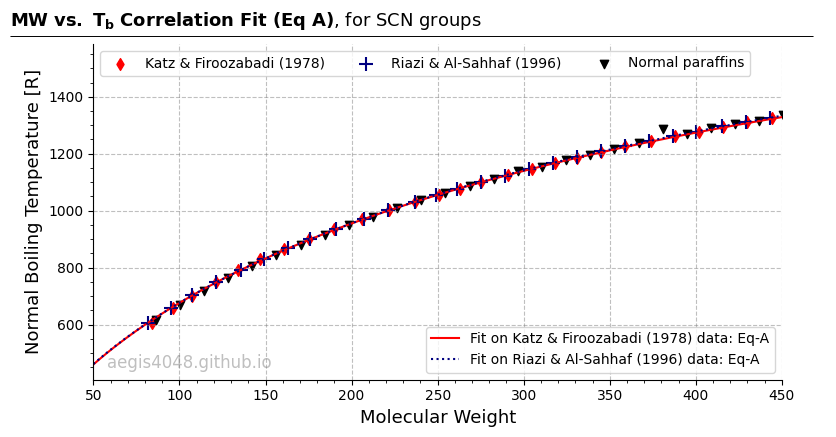

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pint


ureg = pint.UnitRegistry()

df = pd.read_csv('scn_table.csv')

MW_1 = df['MW [K&F]'].dropna()
Tb_1 = df['Tb [R] [K&F]'].dropna()

MW_2 = df['MW [R&A]']
Tb_2 = df['Tb [R] [R&A]']

MW_3 = df['MW [Normal Paraffins]']
Tb_3 = df['Tb [R] [Normal Paraffins]']

################################## Model Fit ################################################

def predict_Tb_from_mw(MW, a, b, c):
    return a - np.exp(b - c * MW ** (2/3))  # 2/3 is an empirically chosen hyper parameter

popt_KF, pcov = curve_fit(predict_Tb_from_mw, MW_1, Tb_1, p0=[1080, 0.3, 0.3])
popt_RA, pcov = curve_fit(predict_Tb_from_mw, MW_2, Tb_2, p0=[1080, 0.3, 0.3])

x = np.arange(50, 500, 2)
y_KF = predict_Tb_from_mw(x, *popt_KF)
y_RA = predict_Tb_from_mw(x, *popt_RA)

#############################################################################################

fig, ax = plt.subplots(figsize=(8, 4.5))

line1, = ax.plot(x, y_KF, label='Fit on Katz & Firoozabadi (1978) data: Eq-A', c='r')
line2, = ax.plot(x, y_RA, label='Fit on Riazi & Al-Sahhaf (1996) data: Eq-A', c='navy', ls='dotted')

scatter1 = ax.scatter(MW_1, Tb_1, label='Katz & Firoozabadi (1978)', marker='d', c='red')
scatter2 = ax.scatter(MW_2, Tb_2, label='Riazi & Al-Sahhaf (1996)', marker='+', c='navy', s=100)
scatter3 = ax.scatter(MW_3, Tb_3, label='Normal paraffins', marker='v', c='k')

legend1 = ax.legend(handles=[scatter1, scatter2, scatter3], fontsize=10, ncol=3, loc='upper left')
ax.add_artist(legend1)
ax.legend(handles=[line1, line2], loc='lower right', fontsize=10)


ax.minorticks_on()
ax.grid(axis='y', which='major', linestyle='--', color='grey', alpha=0.5)
ax.grid(axis='x', which='major', color='grey', linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Molecular Weight', fontsize=13)
ax.set_ylabel('Normal Boiling Temperature [R]', fontsize=13)
ax.text(0.02, 0.05, 'aegis4048.github.io', fontsize=12, ha='left', va='center',
    transform=ax.transAxes, color='grey', alpha=0.5)

def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

bold_txt = setbold('MW vs. T_{b} Correlation Fit (Eq A)')
plain_txt = r', for SCN groups'
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=13, y=0.96)
yloc = 0.88
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

ax.set_xlim(50, 450)
#ax.set_ylim(0.6, .9999)

fig.tight_layout()

In [33]:
popt_KF

array([1.90846331e+03, 7.55374677e+00, 2.02821209e-02])

In [34]:
popt_RA

array([1.94547935e+03, 7.56885268e+00, 1.96209827e-02])

In [38]:
def eq1a(MW, a, b, c):
    return a - np.exp(b - c * MW ** (2/3))  # 0.1 is an empirically chosen hyper parameter

Katz & Firoozabadi (1978) -  Predict SG when MW = 93:        0.7149
Katz & Firoozabadi (1978) -  Predict MW when SG = 0.6756:    81.5508

Riazi & Al-Shahhaf (1996) -  Predict SG when MW = 93:        0.722
Riazi & Al-Shahhaf (1996) -  Predict MW when SG = 0.6756:    77.901


In [ ]:
MWs = np.arange(80, 137, 1)

In [ ]:
predict_sg_from_mw(mw)

However, <a href="#eq-2" class="internal-link">Eq-2</a> (blue line plot) fails to predict SG<sub>liq</sub> properly for MW<136 in <a href="#fig-12" class="internal-link">Figure 12</a>. This is highly problematic for gas sample modeling because the molecular weight of the plus fractions of gas sample usually falls in the range of 85~105. In his later publication in 2005<sup><a class="internal-link" href="#id1" id="id11">[1]</a>, chap 4.3</sup>, Riazi mentions that the model is valid for Nc &#8805; 10 (MW&#8805;136), which calls for development of a model that works for smaller SCN groups. I developed a simple 3rd degree polynomial that fits SG<sub>liq</sub> of lower SCN groups well for MW<136 in <a href="#eq-3" class="internal-link">Eq-3</a>. Accuracy of the model performance can be visually evaluated in <a href="#fig-13" class="internal-link">Figure 13</a>.

<div id="eq-3" style="font-size: 1rem;">
$$ SG_{liq} = (3.018 \times 10^{-7})MW^3 - (1.214 \times 10^{-4})MW^2 + 0.01719MW - 0.06947  \space  \space  \space  \space  \space  \text{for MW<136} \tag{3}$$
</div>

Combining <a href="#eq-2" class="internal-link">Eq-2</a> and <a href="#eq-3" class="internal-link">Eq-3</a> gives a piece-wise function shown in <a href="#eq-4" class="internal-link">Eq-4</a>, which has a working range between 6&#8804;SCN&#8804;50 (82&#8804;MW&#8804;698). Check <a href="#fig-14" class="internal-link">Figure 14</a> for visual inspection of the final model.

<div id="eq-4" style="font-size: 1rem;">
$$ SG_{liq}=   \left\{
    \begin{array}{ll}
          (3.018 \times 10^{-7})MW^3 - (1.214 \times 10^{-4})MW^2 + 0.01719MW - 0.06947 & \text{for } MW < 136,  \\
           1.07 - \text{exp}(3.56073 - 2.93886MW^{0.1}) &  \text{for } MW \geq 136  \\
    \end{array} 
    \right.  
    \tag{4}$$
</div>

<a href="#table-2" class="internal-link">Table 2</a> provides a tabulated MW-SG<sub>liq</sub> data generated with <a href="#eq-4" class="internal-link">Eq-4</a> for quick lookup of gas samples between 80&#8804;MW&#8804;136. Since the max plus fraction reported for gas samples is Decanes+, SCN=10 with MW=136 should cover all observable ranges of gas plus fractions. 

<div class="row full_screen_margin_80 mobile_responsive_plot_full_width" id="fig-12">
<div class="col"><img src="jupyter_images/liquid_sg_scn_model_riazi_original2.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 12:</strong> Comparison of SCN models and normal paraffins. Real-life plus fractions contain naphthenic and aromationc fractions, which are known to have higher SG<sub>liq</sub> than paraffins at a given MW, as shown in <a href="#fig-2" class="internal-link">Figure 2</a> above. The values of normal paraffins are obtained with <a href="#code_snippet_1" class="internal-link">Code Snippet #1</a>.</p></div>

<div class="solution_panel closed" style="margin-top: -10px">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (12)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('scn_table.csv')

MW_1 = df['MW [K&F]']
SG_1 = df['SG [K&F]']
Tb_1 = df['Tb [R] [K&F]']

MW_2 = df['MW [R&A]']
SG_2 = df['SG [R&A]']
Tb_2 = df['Tb [R] [R&A]']

MW_3 = df['MW [Normal Paraffins]']
SG_3 = df['SG [Normal Paraffins]']
Tb_3 = df['Tb [R] [Normal Paraffins]']

def calc_sg_liq_riazi(mw):
    return 1.07 - np.exp(3.56073 - 2.93886 * mw**0.1)

x = np.arange(80, 500, 2)
y_riazi = np.array([calc_sg_liq_riazi(mw) for mw in x])

fig, ax = plt.subplots(figsize=(8, 4.5))

line1, = ax.plot(x, y_riazi, label='Riazi & Al-Sahhaf (1996): $SG_{liq}=a_1-exp(a_2 - a_3 \cdot MW^{a_4})$')

scatter1 = ax.scatter(MW_1, SG_1, label='Katz & Firoozabadi (1978)', marker='d', c='red')
scatter2 = ax.scatter(MW_2, SG_2, label='Riazi & Al-Sahhaf (1996)', marker='+', c='navy', s=100)
scatter3 = ax.scatter(MW_3, SG_3, label='Normal paraffins', marker='v', c='k')

legend1 = ax.legend(handles=[scatter1, scatter2, scatter3], fontsize=10, ncol=3, loc='upper left')
ax.add_artist(legend1)
ax.legend(handles=[line1], loc='lower right', fontsize=10)


ax.minorticks_on()
ax.grid(axis='y', which='major', linestyle='--', color='grey', alpha=0.5)
ax.grid(axis='x', which='major', color='grey', linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Molecular Weight', fontsize=13)
ax.set_ylabel('Liquid Specific Gravity', fontsize=13)
ax.text(0.02, 0.05, 'aegis4048.github.io', fontsize=12, ha='left', va='center',
    transform=ax.transAxes, color='grey', alpha=0.5)

ax.text(0.7, 0.23, '$a_1$=1.07', fontsize=10, ha='left', va='center', transform=ax.transAxes)
ax.text(0.7, 0.17, '$a_2$=3.56073', fontsize=10, ha='left', va='center', transform=ax.transAxes)
ax.text(0.85, 0.23, '$a_3$=2.93886', fontsize=10, ha='left', va='center', transform=ax.transAxes)
ax.text(0.85, 0.17, '$a_4$=0.1', fontsize=10, ha='left', va='center', transform=ax.transAxes)

def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

bold_txt = setbold('MW vs. SG_{liq} Correlation by Riazi')
plain_txt = r', for SCN groups'
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=13, y=0.96)
yloc = 0.88
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

ax.set_xlim(50, 450)
ax.set_ylim(0.6, .9999)

fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

<div class="row full_screen_margin_80 mobile_responsive_plot_full_width" id="fig-13">
<div class="col"><img src="jupyter_images/liquid_sg_scn_model_new_fit.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 13:</strong> 3rd degree polynomial fit with <a href="#eq-3" class="internal-link">Eq-3</a> for MW &lt; 136. This new model fits lower MW data points better than Riazi's original model (<a href="#eq-2" class="internal-link">Eq-2</a>).</p></div>

<div class="solution_panel closed" style="margin-top: -10px">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (13)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('scn_table.csv')

MW_1 = df['MW [K&F]']
SG_1 = df['SG [K&F]']
Tb_1 = df['Tb [R] [K&F]']

MW_2 = df['MW [R&A]']
SG_2 = df['SG [R&A]']
Tb_2 = df['Tb [R] [R&A]']

MW_3 = df['MW [Normal Paraffins]']
SG_3 = df['SG [Normal Paraffins]']
Tb_3 = df['Tb [R] [Normal Paraffins]']

def calc_sg_liq_upto_136(mw):
    return 3.0184e-7 * mw**3 - 1.2139e-4 * mw**2 + 1.7187e-2 * mw - 6.9473e-2

x = np.arange(80, 138, 2)
y_136 = np.array([calc_sg_liq_upto_136(mw) for mw in x])

fig, ax = plt.subplots(figsize=(8, 4.5))

line1, = ax.plot(x, y_136, label='New Fit for MW < 136: Eq-3', c='#ff7f0e')

scatter1 = ax.scatter(MW_1, SG_1, label='Katz & Firoozabadi (1978)', marker='d', c='red')
scatter2 = ax.scatter(MW_2, SG_2, label='Riazi & Al-Sahhaf (1996)', marker='+', c='navy', s=100)
scatter3 = ax.scatter(MW_3, SG_3, label='Normal paraffins', marker='v', c='k')

legend1 = ax.legend(handles=[scatter1, scatter2, scatter3], fontsize=10, ncol=3, loc='upper left')
ax.add_artist(legend1)
ax.legend(handles=[line1], loc='lower right', fontsize=10)


ax.minorticks_on()
ax.grid(axis='y', which='major', linestyle='--', color='grey', alpha=0.5)
ax.grid(axis='x', which='major', color='grey', linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Molecular Weight', fontsize=13)
ax.set_ylabel('Liquid Specific Gravity', fontsize=13)
ax.text(0.02, 0.05, 'aegis4048.github.io', fontsize=12, ha='left', va='center',
    transform=ax.transAxes, color='grey', alpha=0.5)



def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

bold_txt = setbold('Modified MW vs. SG_{liq} Correlation')
plain_txt = r', for MW < 136'
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=13, y=0.96)
yloc = 0.88
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

ax.set_xlim(79.5, 140)
ax.set_ylim(0.68001, .7999)

fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

<div class="row full_screen_margin_80 mobile_responsive_plot_full_width" id="fig-14">
<div class="col"><img src="jupyter_images/liquid_sg_scn_piecewise_model.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 14:</strong> Piecewise function from <a href="#eq-4" class="internal-link">Eq-4</a>. Note that while the function can be extended infinitely, the model has been tested only for 82 &lt; MW &lt; 698. Extrapolation beyond this tested range should be performed with caution.</p></div>

<div class="solution_panel closed" style="margin-top: -10px">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (14)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('scn_table.csv')

MW_1 = df['MW [K&F]']
SG_1 = df['SG [K&F]']
Tb_1 = df['Tb [R] [K&F]']

MW_2 = df['MW [R&A]']
SG_2 = df['SG [R&A]']
Tb_2 = df['Tb [R] [R&A]']

MW_3 = df['MW [Normal Paraffins]']
SG_3 = df['SG [Normal Paraffins]']
Tb_3 = df['Tb [R] [Normal Paraffins]']

def calc_sg_liq_riazi(mw):
    return 1.07 - np.exp(3.56073 - 2.93886 * mw**0.1)

def calc_sg_liq_modified(mw):
    return 3.0184e-7 * mw**3 - 1.2139e-4 * mw**2 + 1.7187e-2 * mw - 6.9473e-2

def calc_sg_liq_piecewise(mw):
    if mw < 136:
        return calc_sg_liq_modified(mw)
    else:
        return calc_sg_liq_riazi(mw)

x = np.arange(60, 500, 2)
y = np.array([calc_sg_liq_piecewise(mw) for mw in x])

fig, ax = plt.subplots(figsize=(8, 4.5))

line1, = ax.plot(x, y, label='Piecewise model: Eq-4', c='#2ca02c')

scatter1 = ax.scatter(MW_1, SG_1, label='Katz & Firoozabadi (1978)', marker='d', c='red')
scatter2 = ax.scatter(MW_2, SG_2, label='Riazi & Al-Sahhaf (1996)', marker='+', c='navy', s=100)
scatter3 = ax.scatter(MW_3, SG_3, label='Normal paraffins', marker='v', c='k')

legend1 = ax.legend(handles=[scatter1, scatter2, scatter3], fontsize=10, ncol=3, loc='upper left')
ax.add_artist(legend1)
ax.legend(handles=[line1], loc='lower right', fontsize=10)


ax.minorticks_on()
ax.grid(axis='y', which='major', linestyle='--', color='grey', alpha=0.5)
ax.grid(axis='x', which='major', color='grey', linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Molecular Weight', fontsize=13)
ax.set_ylabel('Liquid Specific Gravity', fontsize=13)
ax.text(0.02, 0.05, 'aegis4048.github.io', fontsize=12, ha='left', va='center',
    transform=ax.transAxes, color='grey', alpha=0.5)

def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

bold_txt = setbold('Piecewise Modified MW vs. SG_{liq} Correlation')
plain_txt = r', for SCN groups'
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=13, y=0.96)
yloc = 0.88
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

ax.set_xlim(50, 450)
ax.set_ylim(0.6, .9999)

fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

<div class="row full_screen_margin_75 mobile_responsive_plot_full_width" id="table-1">
<div class="col"><img src="jupyter_images/liquid_sg_scn_tables2.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Table 1:</strong> SCN property tables featuring Katz &amp; Firoozabadi (1978)<sup><a class="internal-link" href="#id4" id="id42">[4]</a></sup>, Riazi &amp; Al-Sahhaf (1996)<sup><a class="internal-link" href="#id5" id="id52">[5]</a></sup>, and normal paraffins. The properites of normal paraffins are extracted with <a href="#code_snippet_1" class="internal-link">Code Snippet #1</a>. Note that the liquid specific gravity for normal paraffins is omitted beyond C16 because the python library used to pull the data reports densites at 60F, which suffers inconsistencies due to paraffins beyond C16 existing as solids at 60F.</p></div>

<div><hr></div>

<strong id="code_snippet_1">Code Snippet #1</strong>

In [6]:
from thermo import ChemicalConstantsPackage  # pip install thermo
import numpy as np
import pint                                  # pip install pint


ureg = pint.UnitRegistry()

density_water = 999.0170125317171, # (kg/m^3) @60F-1atm according to IAPWS-95 standard, chemicals.iapws95_rho(288.706, 101325)

n_paraffins = ['n-C6', 'n-C7', 'n-C8', 'n-C9', 'n-C10',
 'n-C11', 'n-C12', 'n-C13', 'n-C14', 'n-C15', 'n-C16', 'n-C17', 'n-C18', 'n-C19', 'n-C20',
 'n-C21', 'n-C22', 'n-C23', 'n-C24', 'n-C25', 'n-C26', 'n-C27', 'n-C28', 'n-C29', 'n-C30',
 'n-C31', 'n-C32', 'n-C33', 'n-C34', 'n-C35', 'n-C36', 'n-C37', 'n-C38', 'n-C39', 'n-C40',
 'n-C41', 'n-C42', 'n-C43', 'n-C44', 'n-C45', 'n-C46', 'n-C47', 'n-C48', 'n-C49', 'n-C50']

constants = ChemicalConstantsPackage.constants_from_IDs(n_paraffins)
MWs = np.array(constants.MWs)
sgs = np.array(constants.rhol_60Fs_mass) / density_water  # values are invalid after C16 because they are maybe solids at 60F
Tbs = np.array([ureg('%.15f kelvin' % Tb).to('rankine')._magnitude for Tb in np.array(constants.Tbs)])

<div><hr></div>

<div class="row full_screen_margin_90 mobile_responsive_plot_full_width" id="table-2">
<div class="col"><img src="jupyter_images/liquid_sg_scn_tabulated_scn.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Table 2:</strong> Tablulated MW-SG<sub>liq</sub> correlation values for quick lookup using <a href="#eq-4" class="internal-link">Eq-4</a>. The liquid specific gravity values are generated with <a href="#code_snippet_2" class="internal-link">Code Snippet #2</a>. This table should work for all practical modeling of gas samples, since the heaviest plus fraction you will see in gas samples is Decanes+ (SCN=10, MW=136).</p></div>

<div><hr></div>

<strong id="code_snippet_2">Code Snippet #2</strong>

In [8]:
import numpy as np
import pint

ureg = pint.UnitRegistry()

def calc_sg_liq_riazi(mw):
    return 1.07 - np.exp(3.56073 - 2.93886 * mw**0.1)

def calc_sg_liq_modified(mw):
    return 3.0184e-7 * mw**3 - 1.2139e-4 * mw**2 + 1.7187e-2 * mw - 6.9473e-2

def calc_sg_liq_piecewise(mw):
    if mw < 136:
        return calc_sg_liq_modified(mw)
    else:
        return calc_sg_liq_riazi(mw)
    
def calc_Tb(mw):
    Tb = 1080 - np.exp(6.97996 - 0.01964 * mw**(2/3))
    return ureg('%.15f kelvin' % Tb).to('rankine')._magnitude

MWs = np.arange(80, 137, 1)
sgs = np.array([calc_sg_liq_piecewise(mw) for mw in MWs])
Tbs = np.array([calc_Tb(mw) for mw in MWs])

## 5. Excercises

The purpose of the following exercises are to approximate liquid specific gravities (SG<sub>liq</sub>) of gas sample analyses, when then lab reports are missing values of SG<sub>liq</sub>, or making certain assumptions about the composition of the plus fractions (such as 6:3:1 ratio of C6, C7, and C8) instead of performing physical measurements.

### 5.1. Example 1

The sample analysis is given in <a href="#fig-15" class="internal-link">Figure 15</a>. The lab report is a 2-pager extended analysis, with the 2nd page reporting 18 compounds between n-hexane and n-decane. We ignore the "Undecane (11)" for now. 

Realistically the <i>Heptanes Plus</i> fraction can be replaced with simple 6:3:1 ternary mixture of n-hexane, n-heptane, and n-octane since it makes up only 0.344 mol% of the whole sample. The error from the ternary mixture assumption will be negligible. But for the sake of learning, let's assume that we actually care about this. 

At a first glance, it seems that we can simply enter all compounds into a simulation software instead of characterizing a plus fraction, since the extended analysis reports all measured compound mol %. However, taking a second look at it, you can notice some ambiguous compounds such as [Other C7's, Other C8's, Other C8's, Other C9's, Other C10's]. Unfortunately the lab report didn't provide us with detailed definition of the "Other C<sub>n</sub>'s", forcing us to actually characterize the Heptanes Plus fraction.

The lab probably has their own definition of the "Other C<sub>n</sub>'s", and reported MW=95.59 for the plus fraction based on their own definition. Given MW=95.59, SG<sub>liq</sub> can be calculated from <a href="#eq-3" class="internal-link">Eq-3</a>, or can be looked up from <a href="#table-2" class="internal-link">Table 2</a>, giving SG<sub>liq</sub>=0.7279. The sample now has both values of MW and SG<sub>liq</sub> and can be modeled in a simulation software, as in <a href="#fig-16" class="internal-link">Figure 16</a>

<div class="row full_screen_margin_80 mobile_responsive_plot_full_width" id="fig-15">
<div class="col"><img src="jupyter_images/liquid_sg_excercise_1.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 15:</strong> Example gas analysis 1.</p></div>

<div class="row full_screen_margin_60 mobile_responsive_plot_full_width" id="fig-16">
<div class="col"><img src="jupyter_images/liquid_sg_excercise_1_promax.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 16:</strong> Promax simulation result for the example gas analysis 1.</p></div>

### 5.2. Example 2

The sample analysis is given in <a href="#fig-17" class="internal-link">Figure 17</a>. This particular sample is a natural gas liquid (NGL) taken from a pressurized stream. Operators sometimes choose to sell the rich vapors in a liquid phase from the gas outlet of low pressure vessels such as heater treater (HT), vapor recovery tower (VRT) or atmospheric tanks because NGLs are sold for a higher price than the equivalent MMBtu gas. Usually the NGLs are sold for half the price of crude oils. The rich vapors can be knocked out as NGLs with compression, and stored in pressurized containers. 

<div class="row full_screen_margin_90 mobile_responsive_plot_full_width" id="fig-17">
<div class="col"><img src="jupyter_images/liquid_sg_excercise_2.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 17:</strong> Example gas analysis 2.</p></div>

<div><hr></div>

This sample analysis is provided from the same laboratory as in <a href="#fig-10" class="internal-link">Figure 10</a> above. The difference is that the reported Hexanes Plus properties of this sample are not measured, but assumed. There are two red flags that should raise your eyebrows as you are evaluating this analysis report.

First, the average MW=93.189 can be obtained if you assume 60% n-hexane (MW=86.17), 30% n-heptane (MW=100.21), 10% n-octane (MW=114.23). Their weighted average is 93.188, which matches exactly with the provided mixture MW. This is too convenient to be true if they actually made physical measurements.

Second, notice the small font "Page 1 of 1" at the bottom right corner. If this was an extended analysis, this should be at least a 2-page report in which the 2nd page has detailed measured mole fractions of heavier compounds. If this is not an extended analysis, it means that the Hexanes Plus fraction is not measured.

These two observations indicate that the reported plus fraction properties originate from the 6:3:1 paraffinic ternary mixture, which tends to underestimate SG<sub>liq</sub> as due to contributions from naphthenic and aromatic fractions as shown in <a href="#fig-2" class="internal-link">Figure 2</a> and <a href="#fig-12" class="internal-link">Figure 12</a>. Assuming 100% paraffinic composition results in underestimated SG<sub>liq</sub> for the plus fraction due to contributions from naphthenic and aromatic fractions. <strong><u>This is a significant source of error because the Hexanes Plus fraction make up 60% of the whole sample. The engineer who asked for this sample analysis really should've asked for extended analysis.</u></strong>

But this is how life works, and we gotta deal with what we got. Two remedial procedures exist, but unfortunately both of them rely on making certain assumptions. Here I introduce two options: 

<div class="ordered-list">
    <h2>Option 1:</h2>
    <ol>
        <li>Use your previous knowledge (ex: offset well extended gas analysis taken from similar operating conditions) to guess MW or SG<sub>liq</sub> of the C6+ fraction.</li>
        <li>(Guessing...) Upstream NGLs originate from rich flash vapors from low pressure vessels, such as HT, VRT, or atmospheric tanks that go through compression with VRUs. (My personal experience indicates that... ) The extended analysis taken from these sources typically reported MW range between 87 to 93 for C6+. I will pick a middle point of MW=90</li>
        <li>Quick lookup on <a href="#table-2" class="internal-link">Table 2</a> indicates that a fraction with MW=90 should have SG<sub>liq</sub>=0.714 and T<sub>b</sub>=639.8R</li>
        <li>Create a pseudo-compound C6+.
<div class="row full_screen_margin_60 mobile_responsive_plot_full_width" id="fig-18">
<div class="col"><img src="jupyter_images/liquid_sg_example_2_promax_1.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 18:</strong> Promax simulation for C6+ characterization. MW=90 is empirically chosen from personal experience. The values of corresponding SG<sub>liq</sub> and T<sub>b</sub> are chosen from <a href="#table-2" class="internal-link">Table 2</a>.</p></div>            
        </li>
        <li>Model the whole sample with the C6+ fraction.
<div class="row full_screen_margin_80 mobile_responsive_plot_full_width" id="fig-19">
<div class="col"><img src="jupyter_images/liquid_sg_example_2_promax_2.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 19:</strong> Promax simulation result for the whole sample. </p></div>           
        </li>
    </ol>
</div>


<div class="ordered-list">
    <h2>Option 2:</h2>
    <ol>
        <li>Use ternary mixture with 6:3:1 ratio to replace the C6+ fraction. However, instead of using pure paraffinic mixture composed of n-hexane, n-heptane, and n-octane, use SCN models in <a href="#table-2" class="internal-link">Table 1</a>. This should be more representative of the real sample as the actual plus fraction is a mixture of paraffins, naphthenes, and aromatics.</li>
        <li>Picking the SCN model by Riazi and Al-Sahhaf gives C6 MW=82, SG=0.690, C7 MW=95, SG=0.727, and C8 MW=107, SG=0.749.</li>
        <li>Create SCN fraction objects for C6, C7, and C8 in a process sim software.
<div class="row full_screen_margin_100 mobile_responsive_plot_full_width" id="fig-20">
<div class="col"><img src="jupyter_images/liquid_sg_example_2_promax_3.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 20:</strong> Creating SCN C6, C7, and C8 objects according to the given values in <a href="#table-2" class="internal-link">Table 1</a>.</p></div>             
        </li>
        <li>Distribute the 60.179% Hexanes Plus mol frac % with 6:3:1 ratio. C6=36.1074%, C7=18.0537%, C8=6.0179%.</li>
        <li>Model the whole sample with the SCN ternary mixture.
<div class="row full_screen_margin_80 mobile_responsive_plot_full_width" id="fig-21">
<div class="col"><img src="jupyter_images/liquid_sg_example_2_promax_4.png" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 21:</strong> Promax simulation result for the whole sample. Values of MW is smaller (81.519 vs 79.6)and SG<sub>liq</sub> is bigger (0.6501 vs 0.678) than the default lab assumed values of pure paraffin ternary mixture. This is expected since SCN models incorporate the effects of naphthenes and aromatics, which are known to have lower MW and higher SG<sub>liq</sub> at the same carbon number.</p></div>           
        </li>        
    </ol>
</div>

### 5.3. Example 3

The sample analysis is given in <a href="#fig-19" class="internal-link">Figure 22</a>.

<div class="row full_screen_margin_90 mobile_responsive_plot_full_width" id="fig-22">
<div class="col"><img src="jupyter_images/" style="margin-bottom: 10px;"></div></div>    
<div class="col-12 fig-title"><p class="image-description"><strong>Figure 22:</strong> Example gas analysis 3.</p></div>

In [11]:
from scipy.optimize import minimize

# Molecular weights of the components
MW_hexane = 82
MW_heptane = 95
MW_octane = 107

# Target molecular weight of the mixture
target_MW = 87.665

# Function to calculate the difference between the target MW and the calculated MW of the mixture
def objective(x):
    # x[0], x[1], x[2] are the mole fractions of n-hexane, n-heptane, and n-octane, respectively
    MW_mixture = x[0]*MW_hexane + x[1]*MW_heptane + x[2]*MW_octane
    return abs(MW_mixture - target_MW)

# Constraint: sum of mole fractions = 1
cons = ({'type': 'eq', 'fun': lambda x: x[0] + x[1] + x[2] - 1})

# Initial guess for the mole fractions
x0 = [0.6, 0.3, 0.1]

# Bounds for each mole fraction (0 to 1)
bounds = [(0, 1), (0, 1), (0, 1)]

# Solving the minimization problem
result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=cons)

result_mole_fractions = result.x * 100  # Converting to percentages
result_mole_fractions

array([64.59374057, 26.55469457,  8.85156486])

In [12]:
from scipy.optimize import minimize

# Molecular weights of the components
MW_heptane = 95
MW_octane = 107

# Target molecular weight of the mixture
target_MW = 97.38

# Function to calculate the difference between the target MW and the calculated MW of the mixture
def objective(x):
    # x[0], x[1], x[2] are the mole fractions of n-hexane, n-heptane, and n-octane, respectively
    MW_mixture = x[0]*MW_heptane + x[1]*MW_octane
    return abs(MW_mixture - target_MW)

# Constraint: sum of mole fractions = 1
cons = ({'type': 'eq', 'fun': lambda x: x[0] + x[1] - 1})

# Initial guess for the mole fractions
x0 = [0.75, 0.25]

# Bounds for each mole fraction (0 to 1)
bounds = [(0, 1), (0, 1)]

# Solving the minimization problem
result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=cons)

result_mole_fractions = result.x * 100  # Converting to percentages
result_mole_fractions

array([80.16666127, 19.83333873])

## piecewise modeling

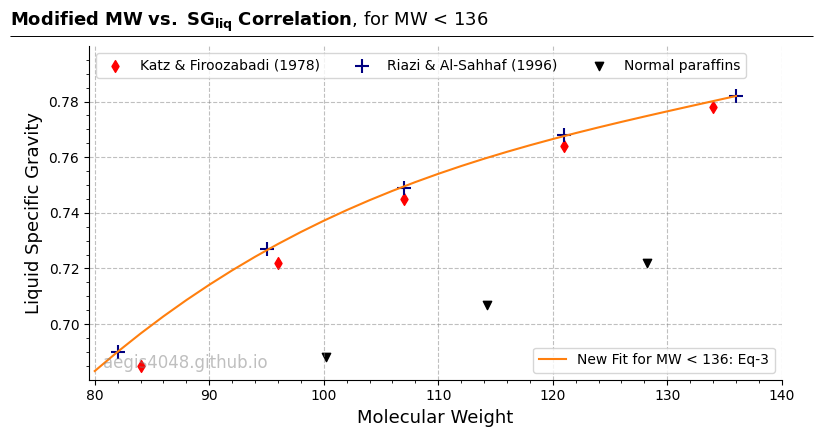

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('scn_table.csv')

MW_1 = df['MW [K&F]']
SG_1 = df['SG [K&F]']
Tb_1 = df['Tb [R] [K&F]']

MW_2 = df['MW [R&A]']
SG_2 = df['SG [R&A]']
Tb_2 = df['Tb [R] [R&A]']

MW_3 = df['MW [Normal Paraffins]']
SG_3 = df['SG [Normal Paraffins]']
Tb_3 = df['Tb [R] [Normal Paraffins]']

def calc_sg_liq_upto_136(mw):
    return 3.0184e-7 * mw**3 - 1.2139e-4 * mw**2 + 1.7187e-2 * mw - 6.9473e-2

x = np.arange(80, 138, 2)
y_136 = np.array([calc_sg_liq_upto_136(mw) for mw in x])

fig, ax = plt.subplots(figsize=(8, 4.5))

line1, = ax.plot(x, y_136, label='New Fit for MW < 136: Eq-3', c='#ff7f0e')

scatter1 = ax.scatter(MW_1, SG_1, label='Katz & Firoozabadi (1978)', marker='d', c='red')
scatter2 = ax.scatter(MW_2, SG_2, label='Riazi & Al-Sahhaf (1996)', marker='+', c='navy', s=100)
scatter3 = ax.scatter(MW_3, SG_3, label='Normal paraffins', marker='v', c='k')

legend1 = ax.legend(handles=[scatter1, scatter2, scatter3], fontsize=10, ncol=3, loc='upper left')
ax.add_artist(legend1)
ax.legend(handles=[line1], loc='lower right', fontsize=10)


ax.minorticks_on()
ax.grid(axis='y', which='major', linestyle='--', color='grey', alpha=0.5)
ax.grid(axis='x', which='major', color='grey', linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Molecular Weight', fontsize=13)
ax.set_ylabel('Liquid Specific Gravity', fontsize=13)
ax.text(0.02, 0.05, 'aegis4048.github.io', fontsize=12, ha='left', va='center',
    transform=ax.transAxes, color='grey', alpha=0.5)



def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

bold_txt = setbold('Modified MW vs. SG_{liq} Correlation')
plain_txt = r', for MW < 136'
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=13, y=0.96)
yloc = 0.88
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

ax.set_xlim(79.5, 140)
ax.set_ylim(0.68001, .7999)

fig.tight_layout()

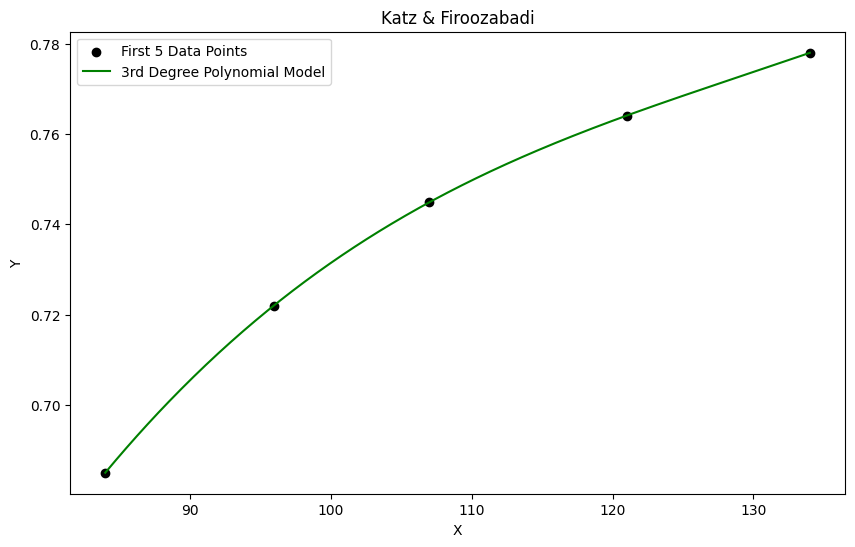

array([ 4.43897660e-07, -1.71830843e-04,  2.32199518e-02, -3.16160530e-01])

In [74]:
# New data arrays provided
x_new = MW_1.values
y_new = SG_1.values

# Focusing on the first 5 data points for the new dataset
x_new_first_5 = x_new[:5]
y_new_first_5 = y_new[:5]

# Fitting a 3rd degree polynomial model to the first 5 data points of the new dataset
coeffs_poly_new_5 = np.polyfit(x_new_first_5, y_new_first_5, 3)
poly_model_new_5_fn = np.poly1d(coeffs_poly_new_5)

# Generating model predictions for plotting
x_model_new_first_5 = np.linspace(min(x_new_first_5), max(x_new_first_5), 400)
y_poly_new_5_plot = poly_model_new_5_fn(x_model_new_first_5)

# Plotting the polynomial model fitted on the first 5 data points of the new dataset
plt.figure(figsize=(10, 6))
plt.scatter(x_new_first_5, y_new_first_5, label='First 5 Data Points', color='black')
plt.plot(x_model_new_first_5, y_poly_new_5_plot, label='3rd Degree Polynomial Model', color='green')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Katz & Firoozabadi')
plt.show()

coeffs_poly_new_5

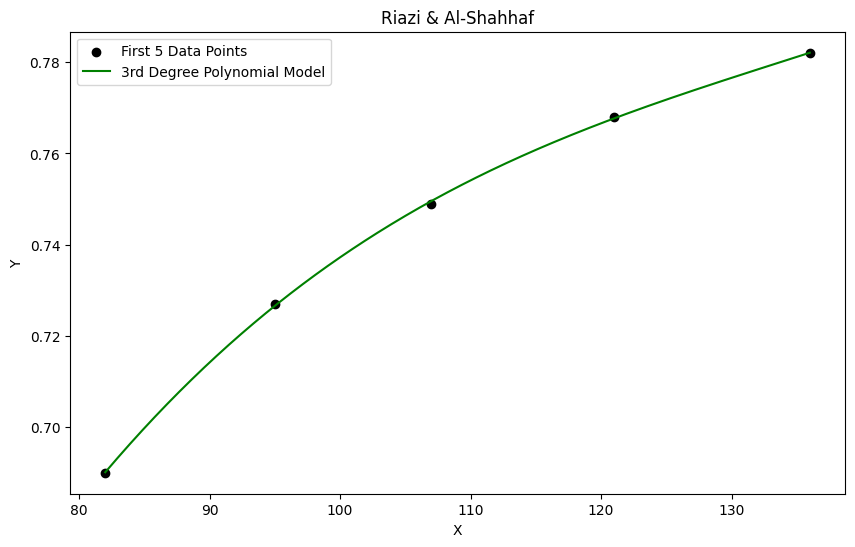

array([ 3.01844792e-07, -1.21389869e-04,  1.71874575e-02, -6.94730209e-02])

In [75]:
# New data arrays provided
x_new = MW_2.values
y_new = SG_2.values

# Focusing on the first 5 data points for the new dataset
x_new_first_5 = x_new[:5]
y_new_first_5 = y_new[:5]

# Fitting a 3rd degree polynomial model to the first 5 data points of the new dataset
coeffs_poly_new_5 = np.polyfit(x_new_first_5, y_new_first_5, 3)
poly_model_new_5_fn = np.poly1d(coeffs_poly_new_5)

# Generating model predictions for plotting
x_model_new_first_5 = np.linspace(min(x_new_first_5), max(x_new_first_5), 400)
y_poly_new_5_plot = poly_model_new_5_fn(x_model_new_first_5)

# Plotting the polynomial model fitted on the first 5 data points of the new dataset
plt.figure(figsize=(10, 6))
plt.scatter(x_new_first_5, y_new_first_5, label='First 5 Data Points', color='black')
plt.plot(x_model_new_first_5, y_poly_new_5_plot, label='3rd Degree Polynomial Model', color='green')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Riazi & Al-Shahhaf')
plt.show()

coeffs_poly_new_5

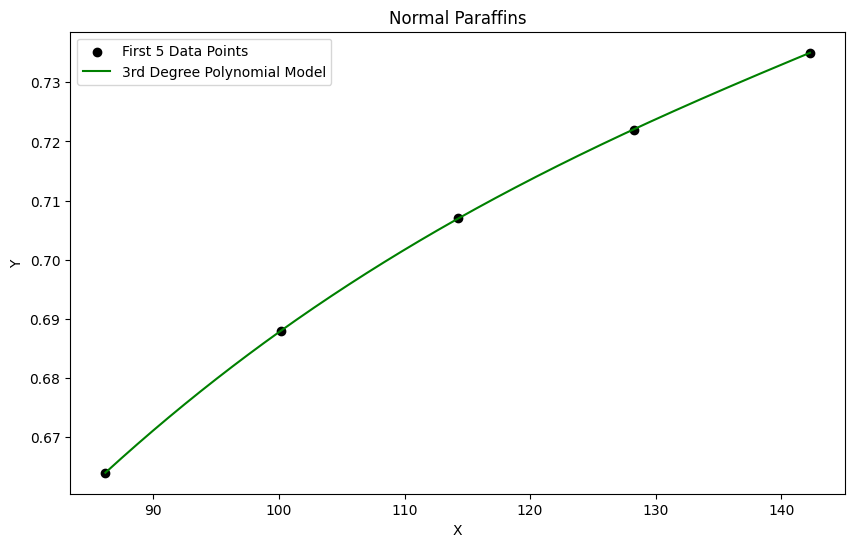

array([ 9.13752871e-08, -4.07558574e-05,  6.92785667e-03,  3.11151107e-01])

In [76]:
# New data arrays provided
x_new = MW_3.values
y_new = SG_3.values

# Focusing on the first 5 data points for the new dataset
x_new_first_5 = x_new[:5]
y_new_first_5 = y_new[:5]

# Fitting a 3rd degree polynomial model to the first 5 data points of the new dataset
coeffs_poly_new_5 = np.polyfit(x_new_first_5, y_new_first_5, 3)
poly_model_new_5_fn = np.poly1d(coeffs_poly_new_5)

# Generating model predictions for plotting
x_model_new_first_5 = np.linspace(min(x_new_first_5), max(x_new_first_5), 400)
y_poly_new_5_plot = poly_model_new_5_fn(x_model_new_first_5)

# Plotting the polynomial model fitted on the first 5 data points of the new dataset
plt.figure(figsize=(10, 6))
plt.scatter(x_new_first_5, y_new_first_5, label='First 5 Data Points', color='black')
plt.plot(x_model_new_first_5, y_poly_new_5_plot, label='3rd Degree Polynomial Model', color='green')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Normal Paraffins')
plt.show()

coeffs_poly_new_5

Fitted parameters: [1.10287083 2.93394797 2.4853261 ]
Mean Absolute Error: 0.00046551852556710383
Mean Relative Error (%): 0.053040738061438594


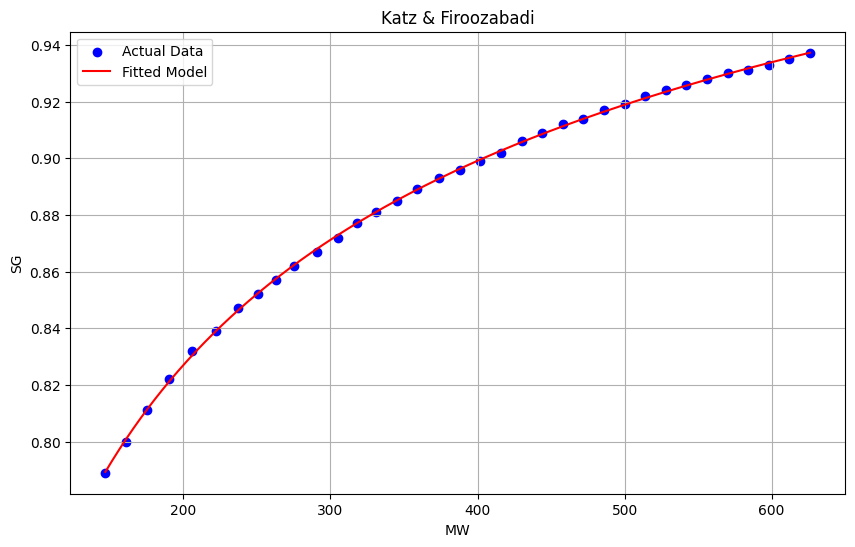

In [77]:
from scipy.optimize import minimize
import numpy as np

# Data
SG = SG_1[~np.isnan(SG_1)]
MW = MW_1[~np.isnan(MW_1)]

n = 5

SG = SG[n:]
MW = MW[n:]

#SG = SG[:n]
#MW = MW[:n]

# Model function
def model(MW, params):
    a, b, c = params
    
    # 0.1 is an empirically chosen hyper parameter
    return a - np.exp(b - c * MW ** 0.1)

# Objective function: Sum of squared residuals
def objective(params):
    predicted_SG = model(MW, params)
    return np.sum((SG - predicted_SG) ** 2)

# Initial guess
initial_guess = [1.07, 0.356073, 0.293886]

# Minimization
result = minimize(objective, initial_guess, method='L-BFGS-B')

predicted_SG = model(MW, result.x)
absolute_errors = np.abs(predicted_SG - SG)
relative_errors = (absolute_errors / SG) * 100  # Multiply by 100 to convert to percentage
mean_absolute_error = np.mean(absolute_errors)
mean_relative_error = np.mean(relative_errors)

if result.success:
    fitted_params = result.x
    print("Fitted parameters:", fitted_params)
    print("Mean Absolute Error:", mean_absolute_error)
    print("Mean Relative Error (%):", mean_relative_error)
else:
    print("Optimization failed:", result.message)

# Plotting (if the optimization is successful)
if result.success:
    plt.figure(figsize=(10, 6))
    plt.scatter(MW, SG, label='Actual Data', color='blue')
    MW_range = np.linspace(min(MW), max(MW), 400)
    plt.plot(MW_range, model(MW_range, fitted_params), label='Fitted Model', color='red')
    plt.xlabel('MW')
    plt.ylabel('SG')
    plt.title('Katz & Firoozabadi')
    plt.legend()
    plt.grid(True)
    plt.show()

Fitted parameters: [1.0784661  3.40294293 2.82446875]
Mean Absolute Error: 0.0005036221738788419
Mean Relative Error (%): 0.057428424914932004


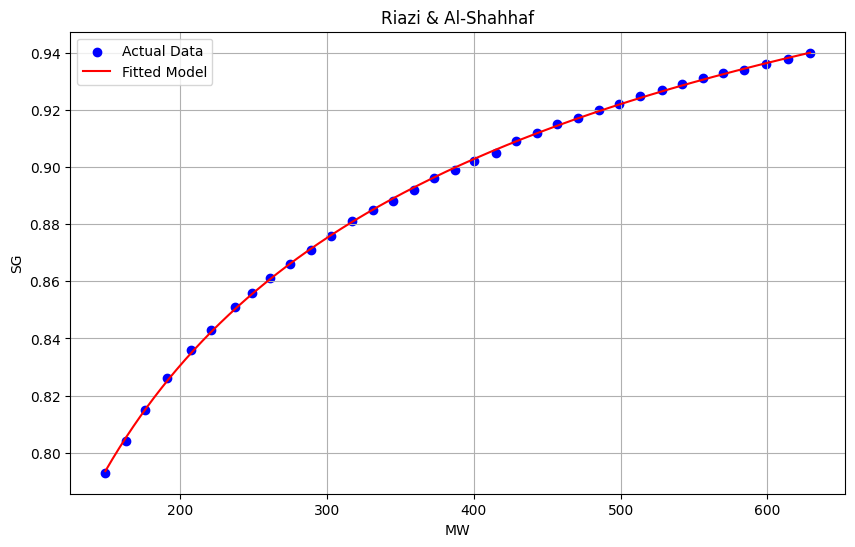

In [78]:
from scipy.optimize import minimize
import numpy as np

# Data
SG = SG_2[~np.isnan(SG_1)]
MW = MW_2[~np.isnan(MW_1)]

n = 5

SG = SG[n:]
MW = MW[n:]

#SG = SG[:n]
#MW = MW[:n]

# Model function
def model(MW, params):
    a, b, c = params
    
    # 0.1 is an empirically chosen hyper parameter
    return a - np.exp(b - c * MW ** 0.1)

# Objective function: Sum of squared residuals
def objective(params):
    predicted_SG = model(MW, params)
    return np.sum((SG - predicted_SG) ** 2)

# Initial guess
initial_guess = [1.07, 0.356073, 0.293886]

# Minimization
result = minimize(objective, initial_guess, method='L-BFGS-B')

predicted_SG = model(MW, result.x)
absolute_errors = np.abs(predicted_SG - SG)
relative_errors = (absolute_errors / SG) * 100  # Multiply by 100 to convert to percentage
mean_absolute_error = np.mean(absolute_errors)
mean_relative_error = np.mean(relative_errors)

if result.success:
    fitted_params = result.x
    print("Fitted parameters:", fitted_params)
    print("Mean Absolute Error:", mean_absolute_error)
    print("Mean Relative Error (%):", mean_relative_error)
else:
    print("Optimization failed:", result.message)

# Plotting (if the optimization is successful)
if result.success:
    plt.figure(figsize=(10, 6))
    plt.scatter(MW, SG, label='Actual Data', color='blue')
    MW_range = np.linspace(min(MW), max(MW), 400)
    plt.plot(MW_range, model(MW_range, fitted_params), label='Fitted Model', color='red')
    plt.xlabel('MW')
    plt.ylabel('SG')
    plt.title('Riazi & Al-Shahhaf')
    plt.legend()
    plt.grid(True)
    plt.show()

Fitted parameters: [1.39136721 0.90098004 0.80659043]
Mean Absolute Error: 0.0006251769939303875
Mean Relative Error (%): 0.08243748528542345


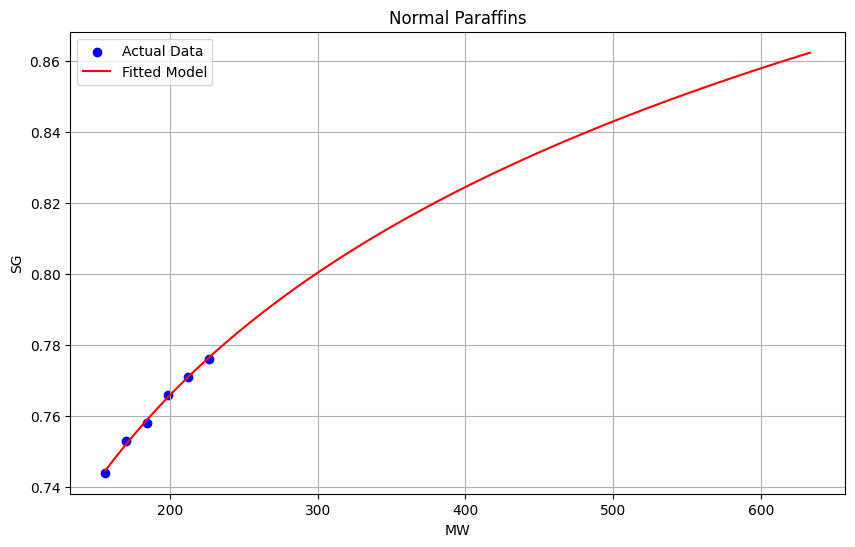

In [79]:
from scipy.optimize import minimize
import numpy as np

# Data
SG = SG_3[~np.isnan(SG_1)]
MW = MW_3[~np.isnan(MW_1)]

n = 5

SG = SG[n:]
MW = MW[n:]

#SG = SG[:n]
#MW = MW[:n]

# Model function
def model(MW, params):
    a, b, c = params
    
    # 0.1 is an empirically chosen hyper parameter
    return a - np.exp(b - c * MW ** 0.1)

# Objective function: Sum of squared residuals
def objective(params):
    predicted_SG = model(MW, params)
    return np.sum((SG - predicted_SG) ** 2)

# Initial guess
initial_guess = [1.07, 0.356073, 0.293886]

# Minimization
result = minimize(objective, initial_guess, method='L-BFGS-B')

predicted_SG = model(MW, result.x)
absolute_errors = np.abs(predicted_SG - SG)
relative_errors = (absolute_errors / SG) * 100  # Multiply by 100 to convert to percentage
mean_absolute_error = np.mean(absolute_errors)
mean_relative_error = np.mean(relative_errors)

if result.success:
    fitted_params = result.x
    print("Fitted parameters:", fitted_params)
    print("Mean Absolute Error:", mean_absolute_error)
    print("Mean Relative Error (%):", mean_relative_error)
else:
    print("Optimization failed:", result.message)

# Plotting (if the optimization is successful)
if result.success:
    plt.figure(figsize=(10, 6))
    plt.scatter(MW, SG, label='Actual Data', color='blue')
    MW_range = np.linspace(min(MW), max(MW), 400)
    plt.plot(MW_range, model(MW_range, fitted_params), label='Fitted Model', color='red')
    plt.xlabel('MW')
    plt.ylabel('SG')
    plt.title('Normal Paraffins')
    plt.legend()
    plt.grid(True)
    plt.show()

## 6. References

<span id="id1" ><strong>[1](<a class="internal-link" href="#id11" style="content: none;">1</a>, <a class="internal-link" href="#id12" style="content: none;">2</a>)</strong></span> Riazi, M. R.: "Characterization and Properties of Petroleum Fractions," (2005), West Conshohocken, Pennsylvania: ASTM International

<span id="id2"><strong>[2](<a class="internal-link" href="#id21" style="content: none;">1</a>, <a class="internal-link" href="#id22" style="content: none;">2</a>, <a class="internal-link" href="#id23" style="content: none;">3</a>, <a class="internal-link" href="#id24" style="content: none;">4</a>)</strong></span> GPA Mistream Association: "GPA Midstream Standard 2145, Table of Physical Properties for Hydrocarbons and Other Compounds of Interest to the Natural Gas and Natural Gas Liquids Industries" (2016)

<span id="id3"><strong>[3](<a class="internal-link" href="#id31" style="content: none;">1</a>)</strong></span> GPA Mistream Association: "GPA Midstream Standard 2286, Tentative Method of Extended Analysis for Natural Gas and Similar Gaseous Mixtures by Temperature Programmed Gas Chromatography" (1995)

<span id="id4"><strong>[4](<a class="internal-link" href="#id41" style="content: none;">1</a>, <a class="internal-link" href="#id42" style="content: none;">2</a>)</strong></span> Katz, D.L., Firoozabadi, A.: "Predicting Phase Behavior of Condensate/Crude-Oil Systems Using Methane Interaction Coefficients" (1978)

<span id="id5"><strong>[5](<a class="internal-link" href="#id51" style="content: none;">1</a>, <a class="internal-link" href="#id52" style="content: none;">2</a>)</strong></span> Riazi, M.R., and Al-Sahhaf, T.A.: "Physical Properties of Heavy Petroleum Fractions and Crude Oils" (1996)

<span id="id6"><strong>[6](<a class="internal-link" href="#id61" style="content: none;">1</a>)</strong> Stratiev, D., Sotirov, S., Sotirova, E., Nenov, S., Dinkov, R., Shishkova, I., Kolev, I.V., Yordanov, D., Vasilev, S., Atanassov, K., Simeonov, S., and Palichev, G.N. "Prediction of Molecular Weight of Petroleum Fluids by Empirical Correlations and Artificial Neuron Networks". MDPI (2023)</span>




<span id="id3"><strong>[3](<a class="internal-link" href="#id31" style="content: none;">1</a>)</strong></span> Riazi, M.R., and Al-Sahhaf, T.A.: "Physical Properties of Heavy Petroleum Fractions and Crude Oils" (1996), Fluid Phase Equilibria 117.

<span id="id4"><strong>[4](<a class="internal-link" href="#id41" style="content: none;">1</a>)</strong></span> Speight, J. G.: "The Chemistry and Technology of Petroleum," 3rd ed., Marcel Dekker, New York, 1999
